# 0.課題

## ● 個人課題
* 次元削減による特微量抽出（主成分分析等)
* クラスタリング（エルボー法)
* 特微量エンジニアリング
* 最高スコアの更新

## ● 講座課題

* k最近傍法を適切に利用できているか？
* 特徴抽出（次元削減）を適切に利用できているか？
* グリッドサーチ、ランダムサーチ、ベイズ最適化を適切に利用できているか
* DAY3後宿題提出時の精度と比較しているか

## ● 前回のモデル・データ情報

* DAY3のベストスコア 0.6486
* 使用データ RFE
* ベストスコアのモデル LGBMClassifier
* パラメータ {'n_estimators': 87, 'max_depth': 11.187104401214084,'subsample': 0.8, 'min_child_weight': 8, 'colsample_bytree': 0.7, 'max_leaf_nodes': 8}

# 1. import

In [1]:
# Basic Library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tqdm
import warnings
warnings.filterwarnings("ignore")

# sklearn utility
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss,f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics   
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from IPython.display import Image

## sklearn ensembles 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression #線形回帰のライブラリ
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from tensorflow import keras  
import tensorflow as tf

## XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

### LightGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb

### CatBoost
from catboost import CatBoostClassifier
import catboost as catboost

## sklearn ensembles 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## パラメータ調整
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression #線形回帰のライブラリ
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

# 2.データ読み込み

In [2]:
df = pd.read_csv("../input/kickstarter/kickstarter-projects.csv")
df = df.drop(['Unnamed: 0','category','backers','country', 'launched', 'deadline',
             'pledged','usd pledged', 'usd_pledged_real'], axis=1)
df.head()

,main_category,currency,goal,state,usd_goal_real,period
0,Publishing,GBP,1000.0,0,1533.95,58
1,Film & Video,USD,30000.0,0,30000.00,59
2,Film & Video,USD,45000.0,0,45000.00,44
3,Music,USD,5000.0,0,5000.00,29
4,Food,USD,50000.0,1,50000.00,34


# 3.データ加工

## 3.1 currency

In [3]:
# pos(Probability Of Success)_currency ：　各通貨ごとの成功率
pos_currency = df.loc[(df["state"] == 1), "currency"].value_counts() / df["currency"].value_counts()
pos_currency

#新たにpos_currency列を作成
df["pos_currency"] = 0

for target_name in pos_currency.index:
    df.loc[df["currency"] == target_name, "pos_currency"] = pos_currency[target_name]
df = df.drop("currency", axis=1)

## 3.2 main_category

### target encoding

In [4]:
def holdout_ts(df, category, label):
    from sklearn.model_selection import StratifiedKFold
    import numpy as np
    
    df_holdout_ts = pd.DataFrame()
    
    # 各属性ごとの(対象カラムの)目的変数の合計とカウントを集計
    agg_df = df.groupby(category).agg({label: ['sum', 'count']})
    # データ分割用のKFoldオブジェクトを生成
    folds = StratifiedKFold(n_splits=3,
                        shuffle=True,
                        random_state=42)
    # 生成特微量の格納用変数作成
    ts = pd.Series(np.empty(df.shape[0]), index=df.index)
    
    # ホールドアウト分を全体から除外した上で平均値を計算
    for _, holdout_idx in folds.split(df, df[label]):
        # ホールドアウトする行を取り出す
        holdout_df = df.iloc[holdout_idx]
        # ホールドアウトしたデータで合計とカウントを計算する
        holdout_agg_df = holdout_df.groupby(category).agg({label : ['sum', 'count']})
        # 全体の集計からホールドアウトした分を引く
        train_agg_df = agg_df - holdout_agg_df
        # ホールドアウトしたデータの平均値を計算していく
        oof_ts = holdout_df.apply(lambda row: train_agg_df.loc[row[category]][(label, 'sum')] \
                                              / (train_agg_df.loc[row[category]][(label, 'count')] + 1), axis=1)
        # 生成した特徴量を記録する
        ts[oof_ts.index] = oof_ts
        
    return ts

### Holdout TS

In [5]:
df["ts_main_category"] = holdout_ts(df, "main_category", "state")
df["ts_main_category"].value_counts()

0.417586    19010
0.417410    18769
0.418687    18748
0.529252    15388
0.525774    15376
0.524752    15185
0.348470    11883
0.346072    11818
0.346469    11744
0.438503     9521
0.441529     9504
0.436613     9496
0.240530     9099
0.233885     9055
0.239108     8896
0.450925     8719
0.417203     8589
0.449740     8501
0.411476     8477
0.445967     8421
0.419054     8298
0.276744     7435
0.274837     7319
0.276110     7300
0.284788     6668
0.278456     6589
0.285186     6518
0.644471     3470
0.637813     3404
0.631418     3368
0.595543     3327
0.341189     3283
0.592997     3282
0.585477     3269
0.339451     3206
0.342527     3200
0.272218     2643
0.270593     2623
0.268654     2552
0.233370     1459
0.249362     1407
0.248343     1283
0.655276     1233
0.654300     1202
0.652709     1138
Name: ts_main_category, dtype: int64

In [6]:
df = df.drop("main_category", axis=1)
df

,goal,state,usd_goal_real,period,pos_currency,ts_main_category
0,1000.0,0,1533.95,58,0.409859,0.348470
1,30000.0,0,30000.00,59,0.418258,0.417586
2,45000.0,0,45000.00,44,0.418258,0.417410
3,5000.0,0,5000.00,29,0.418258,0.524752
4,50000.0,1,50000.00,34,0.418258,0.276110
...,...,...,...,...,...,...
331670,6500.0,0,6500.00,29,0.418258,0.276744
331671,1500.0,0,1500.00,26,0.418258,0.417410
331672,15000.0,0,15000.00,45,0.418258,0.417586
331673,15000.0,0,15000.00,30,0.418258,0.239108


## 3.3 相関係数

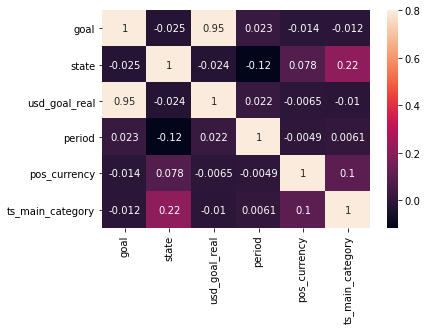

In [7]:
sns.heatmap(df.corr(), vmax=.8, annot=True);

## 3.3 外れ値・欠損値

### 欠損値検出

In [8]:
def missing_values_details(df):
    # null値の合計数
    total = df.isnull().sum()
    # column名とそのカラムの合計欠損値のデータフレーム生成
    missing_df = pd.DataFrame({"count_missing":total}).reset_index().rename(columns = {"index":"column_name"})
    # 欠損率
    missing_df["percent_missing"] = missing_df["count_missing"] / len(df)
    # 欠損数が多い順にsort
    missing_df = missing_df.sort_values(by="count_missing", ascending = False)
    # 欠損数が0ではないレコードだけ抽出
    missing_df = missing_df[missing_df["count_missing"] != 0]
    # 欠損値があるカラム数を表示
    print("Info: {} out of {} columns have missing values".format(len(missing_df), len(df.columns)))
    
    missing_90 = missing_df[missing_df["percent_missing"] > 0.9] 
    missing_80 = missing_df[missing_df["percent_missing"] > 0.8] 
    missing_70 = missing_df[missing_df["percent_missing"] > 0.7] 
    
    print("Info : {} columns have more that 90% missing value".format(len(missing_90)))
    print("Info : {} columns have more that 80% missing value".format(len(missing_80)))
    print("Info : {} columns have more that 70% missing value".format(len(missing_70)))
    
    return missing_df

missing_values_details(df)

Info: 0 out of 6 columns have missing values
Info : 0 columns have more that 90% missing value
Info : 0 columns have more that 80% missing value
Info : 0 columns have more that 70% missing value


,column_name,count_missing,percent_missing


In [9]:
df.dropna(how='any')

,goal,state,usd_goal_real,period,pos_currency,ts_main_category
0,1000.0,0,1533.95,58,0.409859,0.348470
1,30000.0,0,30000.00,59,0.418258,0.417586
2,45000.0,0,45000.00,44,0.418258,0.417410
3,5000.0,0,5000.00,29,0.418258,0.524752
4,50000.0,1,50000.00,34,0.418258,0.276110
...,...,...,...,...,...,...
331670,6500.0,0,6500.00,29,0.418258,0.276744
331671,1500.0,0,1500.00,26,0.418258,0.417410
331672,15000.0,0,15000.00,45,0.418258,0.417586
331673,15000.0,0,15000.00,30,0.418258,0.239108


### 外れ値除外

* ● 以下の理由により、あえて今回は外れ値除去を行わない
* ① 外れ値除去により、「currency」の列がUSDのデータしか残らない(データの多様性が損なわれてしまう）
* ② 外れ値除去により、精度が低下

In [10]:
def detect_outliers(df, n, features):
    """
    -----------------
    df : DataFrame
    n : 閾値
    features : 対象カラム
    ------------------
    外れ値のあるindexを抽出.
    """
    outlier_indices = []

    for col in features:
        q1 = np.percentile(df[col], 25) # 第1四分位数
        q3 = np.percentile(df[col], 75) # 第3四分位数
        iqr = q3 - q1 # 四分位範囲
        
        outlier_step = 1.5 * iqr
        # 第1四分位数以下、第3四分位数以上の値を持つindex抽出
        outlier_list_col = df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step)].index
        print("{} : {} outliers".format(col, len(outlier_list_col)))
        # 配列を結合
        outlier_indices.extend(outlier_list_col)
    # 辞書型(外れ値を持つindex:出現回数)データ生成
    outlier_indices = Counter(outlier_indices)
    # n列以上外れ値を持っているレコードのindex抽出
    multiple_outliers = list(k for k , v in outlier_indices.items() if v > n)
    
    return multiple_outliers

#  外れ値を持つindexを抽出
#outliers_rows =detect_outliers(df, 0, df.columns)
# 外れ値を持つレコード削除
#df_exclude_outlier = df.drop(outliers_rows, axis = 0).reset_index(drop=True)
#df_exclude_outlier

In [ ]:
sns.pairplot(df)

## 3. 標準化/無相関化

In [12]:
def standardization(df):
    sc = StandardScaler()
    return pd.DataFrame(sc.fit_transform(df), columns=df.columns)



df_std = standardization(df.drop(["state", "pos_currency", "ts_main_category"], axis=1))
df_std["pos_currency"] = df["pos_currency"]
df_std["ts_main_category"] = df["ts_main_category"]
df_std["state"] = df["state"]
df_std

,goal,usd_goal_real,period,pos_currency,ts_main_category,state
0,-0.038690,-0.036049,1.969990,0.409859,0.348470,0
1,-0.012748,-0.010379,2.048648,0.418258,0.417586,0
2,0.000669,0.003147,0.868782,0.418258,0.417410,0
3,-0.035111,-0.032924,-0.311084,0.418258,0.524752,0
4,0.005142,0.007656,0.082205,0.418258,0.276110,1
...,...,...,...,...,...,...
331670,-0.033770,-0.031571,-0.311084,0.418258,0.276744,0
331671,-0.038242,-0.036080,-0.547057,0.418258,0.417410,0
331672,-0.026166,-0.023906,0.947440,0.418258,0.417586,0
331673,-0.026166,-0.023906,-0.232426,0.418258,0.239108,0


## 多重共線性チェック

   VIF Factor          features
0   10.808785              goal
1   10.807995     usd_goal_real
2    1.015194            period
3   14.711364      pos_currency
4   15.348530  ts_main_category
5    1.786751             state


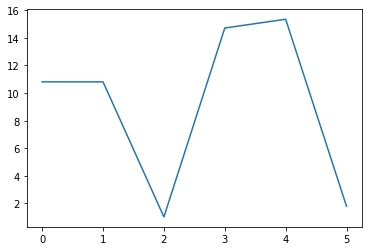

In [13]:
def check_multico(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    #vifを計算する
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    #vifを計算結果を出力する
    print(vif)

    #vifをグラフ化する
    plt.plot(vif["VIF Factor"])
check_multico(df_std)

In [14]:
# usd_goal_realの削除
df_std = df_std .drop(["usd_goal_real"], axis=1)
df_std.head()

,goal,period,pos_currency,ts_main_category,state
0,-0.038690,1.969990,0.409859,0.348470,0
1,-0.012748,2.048648,0.418258,0.417586,0
2,0.000669,0.868782,0.418258,0.417410,0
3,-0.035111,-0.311084,0.418258,0.524752,0
4,0.005142,0.082205,0.418258,0.276110,1


# 4.次元削減

## 4.1 主成分分析

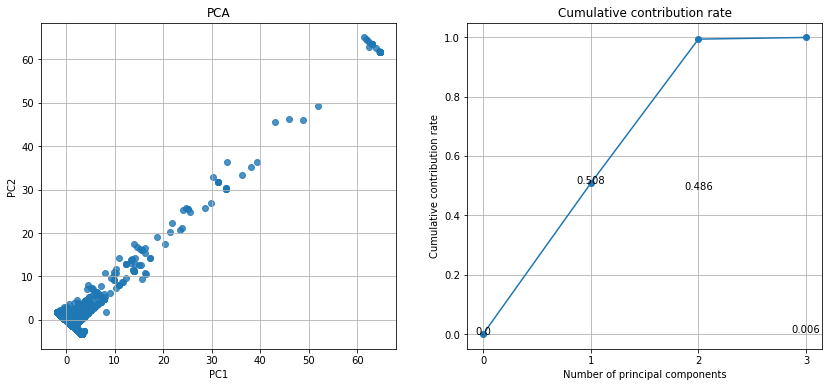

In [15]:
def plot_pca(df,n_components):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # n_components: 抽出したい主成分の数を指定。(通常は元変数より小さい数を設定。)
    pca = PCA(n_components=n_components)
    pca.fit(df)

    # データを主成分空間に写像
    feature = pca.transform(df)
    # 固有値
    contribution_rate= pca.explained_variance_ratio_
    contribution_rate = np.append([0], contribution_rate)

    # 1行2列のaxesを生成
    fig,ax=plt.subplots(1,2,figsize = (14,6))
    ax[0].scatter(feature[:, 0], feature[:, 1], alpha=0.8)
    ax[0].grid()
    ax[0].set_xlabel("PC1")
    ax[0].set_ylabel("PC2")
    ax[0].set_title("PCA")
    
    ax[1].grid()
    ax[1].plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-o")
    ax[1].set_xlabel("Number of principal components")
    ax[1].set_ylabel("Cumulative contribution rate")
    ax[1].set_title("Cumulative contribution rate")
    ax[1].set_xticks(np.arange(0, n_components + 1, 1))
    [ax[1].text(i, value, round(value,3), horizontalalignment='center') for i, value in enumerate(contribution_rate)]

    return pd.DataFrame(feature, columns=["PCA{}".format(i+1) for i in range(len(np.arange(n_components)))])
df_pca = plot_pca(df_std.drop("state", axis=1), 3)

## 4.2 Kernel PCA

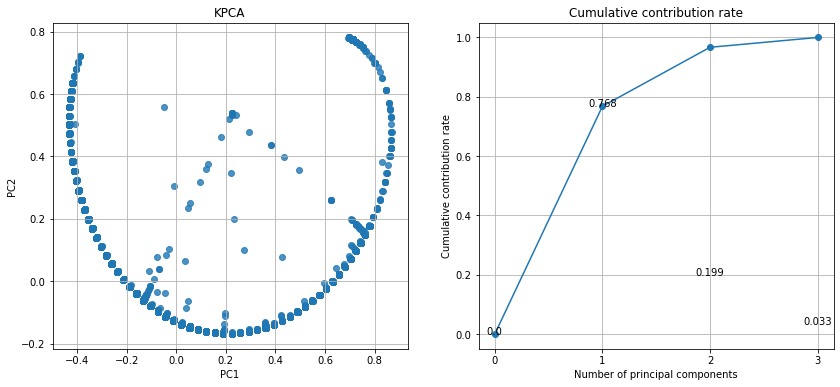

In [16]:
def plot_kernel_pca(df,n_components):
    """
    df : 入力データ
    n_componets : 第n主成分
    """
    from sklearn.decomposition import KernelPCA
    from sklearn.metrics import explained_variance_score
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # n_components: 抽出したい主成分の数を指定。(通常は元変数より小さい数を設定。)
    kpca = KernelPCA(n_components=n_components, kernel="rbf", gamma=0.1, fit_inverse_transform=True)

    # データを主成分空間に写像
    feature = kpca.fit_transform(df)
    # 固有値(KernelPCAの次元単位の分散比（これはX_kpcaの中で分散比を計算すればよい）
    contribution_rate= np.var(feature, axis=0) / np.sum(np.var(feature, axis=0))
    contribution_rate = np.append([0], contribution_rate)

    # 1行2列のaxesを生成
    fig,ax=plt.subplots(1,2,figsize = (14,6))
    ax[0].scatter(feature[:, 0], feature[:, 1], alpha=0.8)
    ax[0].grid()
    ax[0].set_xlabel("PC1")
    ax[0].set_ylabel("PC2")
    ax[0].set_title("KPCA")
    
    ax[1].grid()
    ax[1].plot(list(np.cumsum(contribution_rate)), "-o")
    ax[1].set_xlabel("Number of principal components")
    ax[1].set_ylabel("Cumulative contribution rate")
    ax[1].set_title("Cumulative contribution rate")
    ax[1].set_xticks(np.arange(0, n_components + 1, 1))
    [ax[1].text(i, value, round(value,3), horizontalalignment='center') for i, value in enumerate(contribution_rate)]

    return pd.DataFrame(feature, columns=["KPCA{}".format(i+1) for i in range(len(np.arange(n_components)))])

df_kpca = plot_kernel_pca(df_std.drop("state", axis=1).iloc[:15000, :], 3)

# 5.クラスタリング

## 5.1 非階層的クラスタリング

### k-means++

* クラスタリングプロット用関数

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cluster(X, sta_k, end_k, axis1=0, axis2=1,cluster_pred=2):
    """
    エルボー法グラフ化
    --------------------
    X : 対象データ
    sta_k : スタートクラスタ数
    end_k : エンドクラスタ数
    axis1 : 散布図のx軸の対象列数
    axis2 : 散布図のy軸の対象列数
    cluster_pred : 対象クラスタ数における予測(戻り値)
    """
    before_sse = 0
    sse = []
    diff = []
    pred = []
    centers1 = []
    centers2 = []

    for i in range(sta_k, end_k+1):
        clf = KMeans(n_clusters=i,
                     init="k-means++",      # セントロイドの初期値をランダム選択
                     n_init=10,             # 異なるセントロイドの初期値を用いたk-meansアルゴリズム実行回数
                     max_iter=300,          # k-meansアルゴリズム内部の最大イテレーション回数
                     tol=1e-04,             # 収束と判定するための相対的な許容誤差 
                     random_state=1234)     # セントロイドの初期化に用いる乱数生成器の状態
        
        clf.fit(X)
        pred.append(clf.predict(X))          # ラベル予測
        
        # 散布図の対象列のクラスター中心点
        centers1.append(clf.cluster_centers_[:,axis1]) # 中心点(X軸)
        centers2.append(clf.cluster_centers_[:,axis2]) # 中心点(Y軸)
        
        sse.append(clf.inertia_)                    # SSE
        diff.append(abs(before_sse - clf.inertia_)) # SSEの減少数
        before_sse = clf.inertia_
    
    # 配列の初めに0を代入
    diff[0] = 0

    # 1行2列のaxesを生成
    fig,ax = plt.subplots(end_k-2,2,figsize = (20,24))
    ax[0,0].plot(range(sta_k, end_k+1), sse, marker="o")
    ax[0,0].set_xlabel("Number of clusters")
    ax[0,0].set_ylabel("SSE")
    ax[0,0].set_title("Fluctuation of SSE")
    [ax[0,0].text(i, value, int(value), horizontalalignment='center') for i, value in enumerate(sse)]
    
    ax[0,1].plot(range(sta_k, end_k+1), diff,c="red", marker="o")
    ax[0,1].set_xlabel("Number of clusters")
    ax[0,1].set_ylabel("Number of decrease")
    ax[0,1].set_title("Fluctuation of decrease")
    [ax[0,1].text(i, value, int(value), horizontalalignment='center') for i, value in enumerate(diff)]
    
    # 散布図
    one_dimension_axes = ax.ravel()[2:]
    for i, ax in enumerate(one_dimension_axes):
        #[ax.scatter(X.iloc[:, 0][pred[i] == cls], X.iloc[:, 1][pred[i] == cls], label=cls) for cls in set(pred[i])]
        for cls in set(pred[i]):
            ax.scatter(X.iloc[:, axis1][pred[i] == cls], X.iloc[:, axis2][pred[i] == cls], label="cluster {}".format(cls))
        ax.plot(centers1[i],centers2[i],markersize=20, marker="x",ls="",color="r",label="center")
        ax.set_title("Number of clusters : {}".format(i+1))
        ax.set_xlabel(X.columns[axis1])
        ax.set_ylabel(X.columns[axis2])
        ax.legend(loc="upper left")
    plt.show()
    return pred[cluster_pred]

### エルボー図

#### ①デフォルトデータ（標準化）

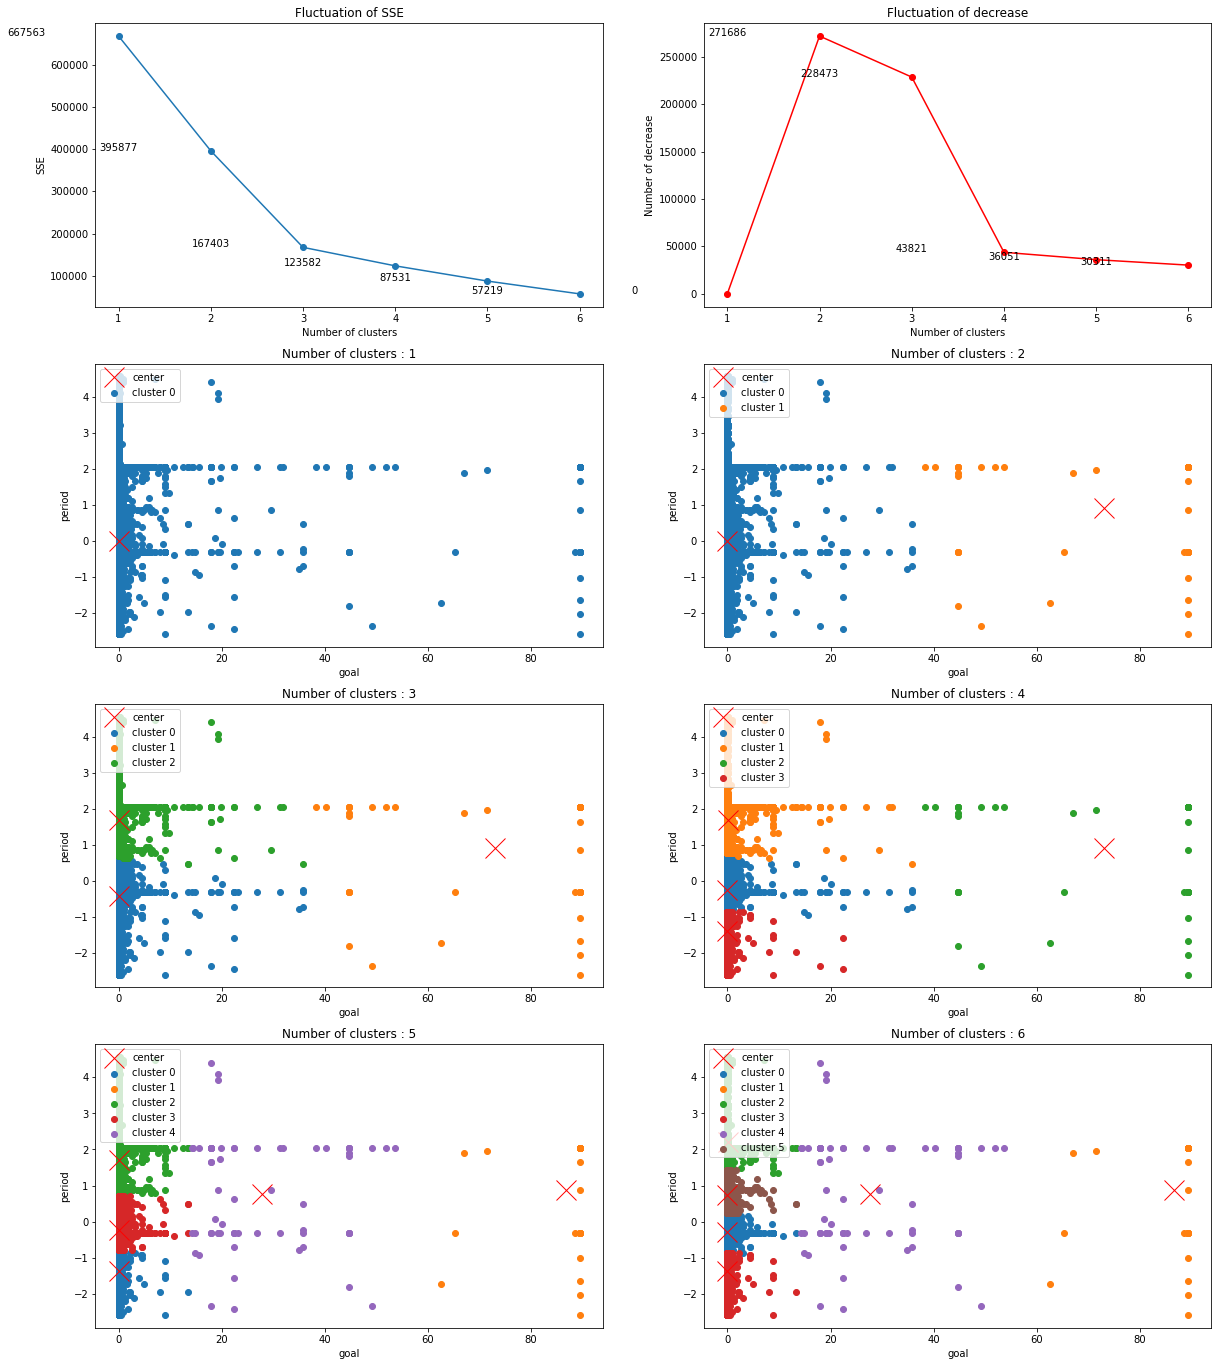

In [18]:
std_pred_cluster = plot_cluster(df_std.drop("state", axis=1),1,6, cluster_pred=3)

#### ②PCA後のデータ

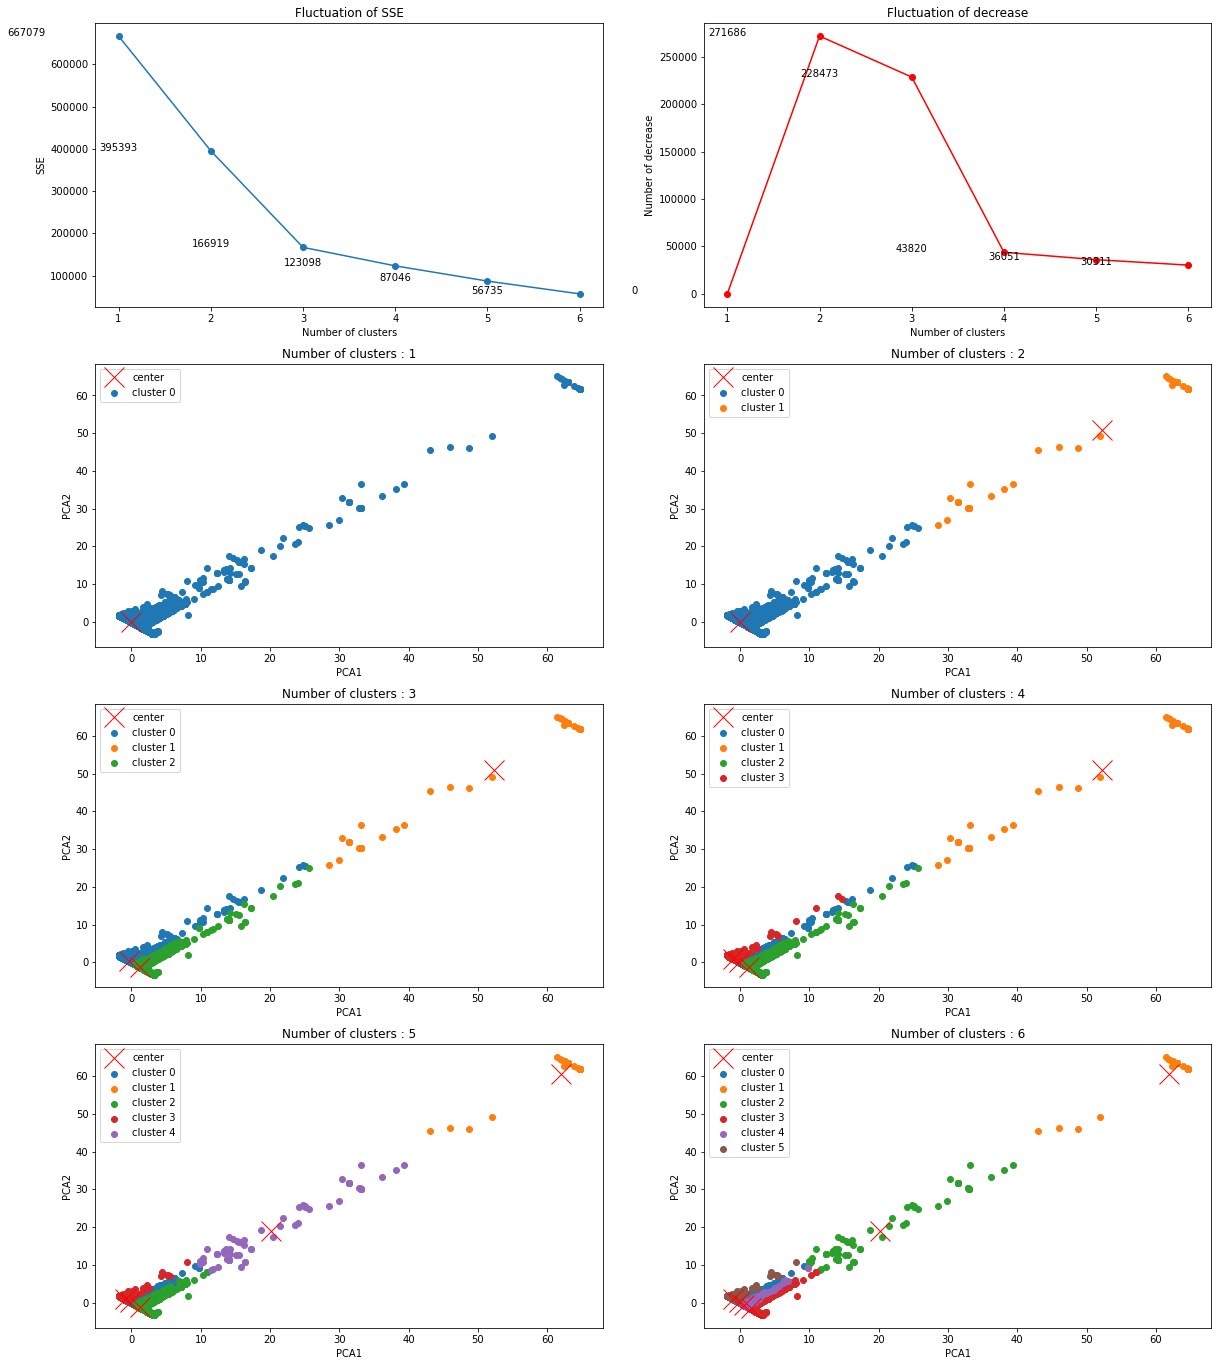

In [19]:
pca_pred_cluster = plot_cluster(df_pca,1,6,cluster_pred=3)

#### ③カーネルPCA後のデータ

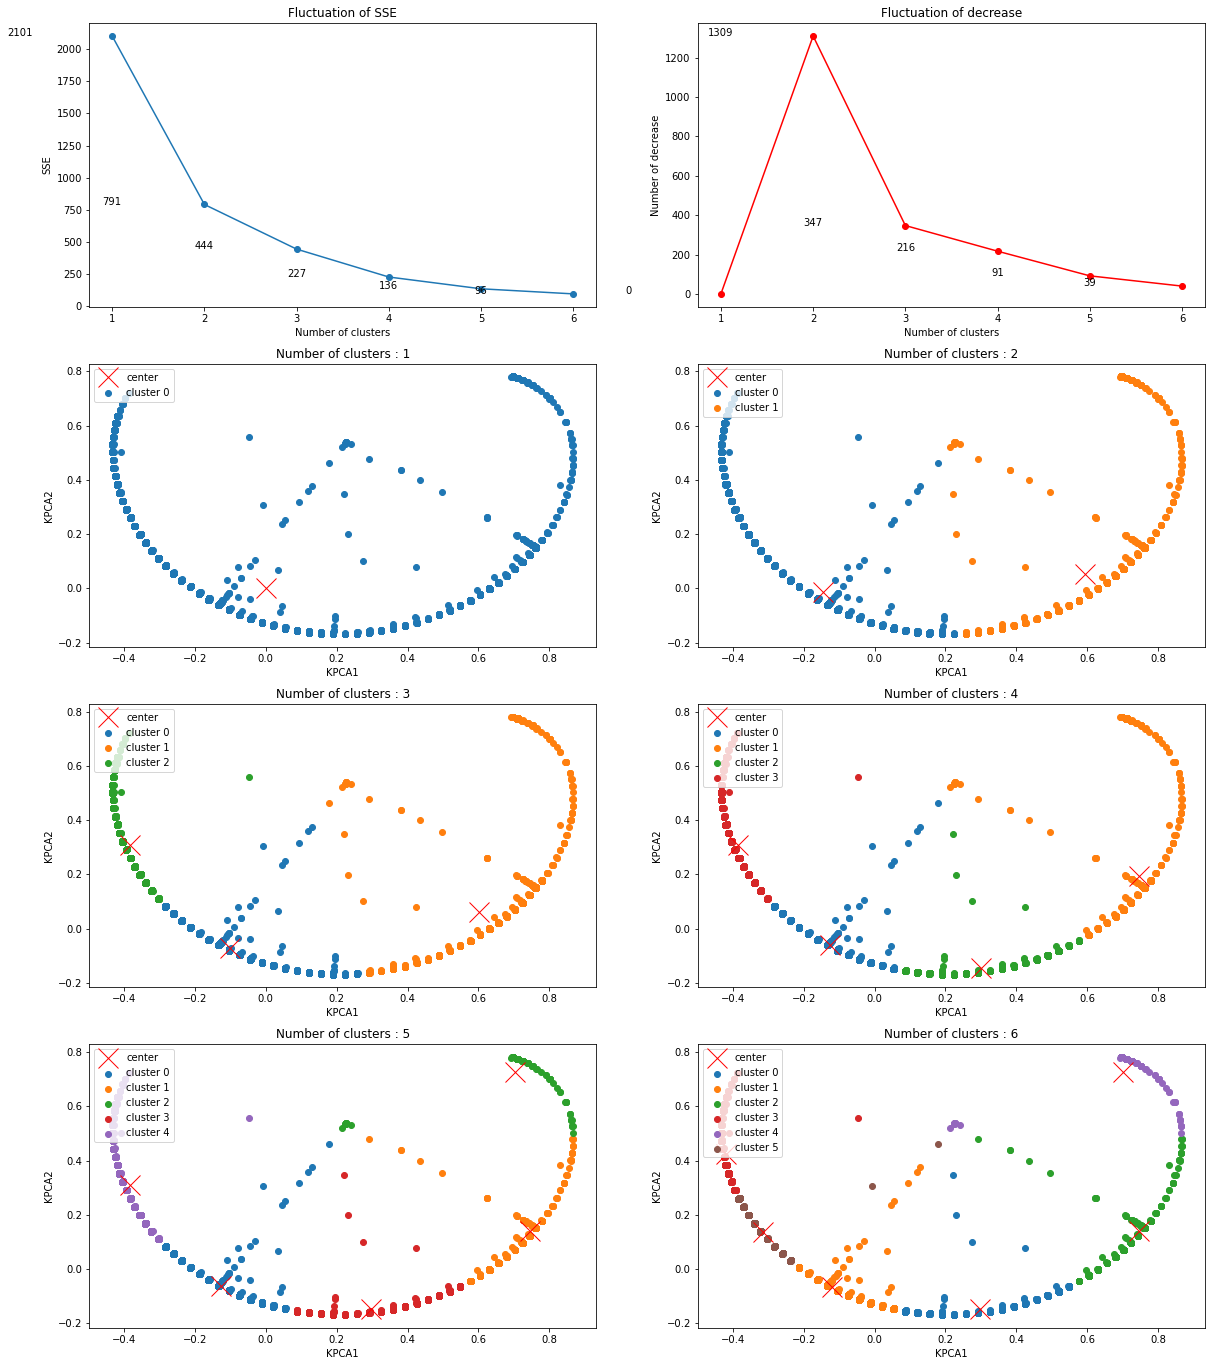

In [20]:
kpca_pred_cluster = plot_cluster(df_kpca,1,6,cluster_pred=3)

### シルエット分析

In [21]:
def plot_silhouette(n_clusters,X):
    """
    n_clusters : クラスタ数
    X : 学習データ
    -------------------------------
    シルエット図でクラスタリング性能を数値化.
    さまざまなクラスタのサイズを細かく調べることで、「外れ値」を含んでいるクラスタを特定.
    シルエット係数の値が1であれば「良いクラスタリング」を示すことになる。
    なお、クラスタリングの適合度を要約するために、シルエット係数の平均（破線）をグラフに追加
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples
    
    clf = KMeans(n_clusters=n_clusters,
             init="k-means++",   # セントロイドの初期値をランダム選択
             n_init=10,          # 異なるセントロイドの初期値を用いたk-meansアルゴリズム実行回数
             max_iter=300,       # k-meansアルゴリズム内部の最大イテレーション回数
             tol=1e-04,          # 収束と判定するための相対的な許容誤差 
             random_state=1234)  # セントロイドの初期化に用いる乱数生成器の状態
    y_km = clf.fit_predict(X)
    
    # ユニークラベルを抽出
    cluster_labels = np.unique(y_km)
    # クラスタ数をカウント
    n_clusters = cluster_labels.shape[0]

    # シルエット係数を計算
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    
    for i, c in enumerate(cluster_labels):
      c_silhouette_vals = silhouette_vals[y_km == c]
      c_silhouette_vals.sort()
      y_ax_upper += len(c_silhouette_vals)
      color = cm.jet(float(i) / n_clusters)   # 色の値をセット
      plt.barh(range(y_ax_lower, y_ax_upper), # 水平の棒グラフを描画（底辺の範囲を指定）
              c_silhouette_vals,              # 棒の幅 
              height=1.0,                     # 棒の高さ
              edgecolor="none",               # 棒の端の色
              color=color)
    
      yticks.append((y_ax_lower + y_ax_upper) / 2.) # クラスタラベルの表示位置を追加
      y_ax_lower += len(c_silhouette_vals)          # 底辺の値に棒の幅を追加
    
    silhouette_avg = np.mean(silhouette_vals)                  # クラスタラベルの表示位置を追加
    plt.axvline(silhouette_avg, color="red", linestyle="--")   # 係数の平均値の破線を引く
    
    plt.yticks(yticks, cluster_labels + 1)                     # クラスタラベルを表示
    plt.ylabel("Cluster")
    plt.xlabel("silhouette coefficient")
    plt.tight_layout()
    plt.show()
    

#### ①デフォルトデータ（標準化）

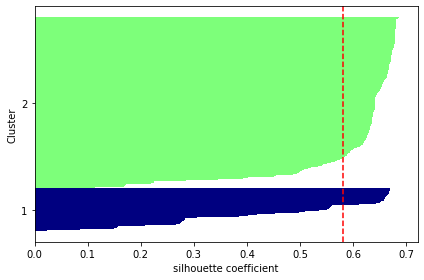

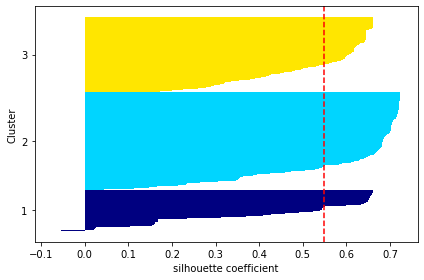

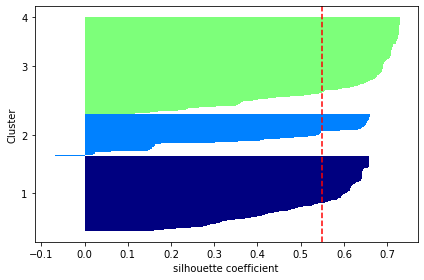

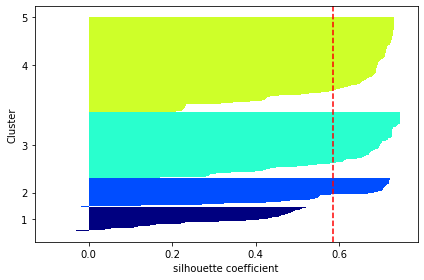

In [22]:
for i in range(2,6):
    plot_silhouette(i, df_std.iloc[:10000, :])

#### ②PCA後のデータ

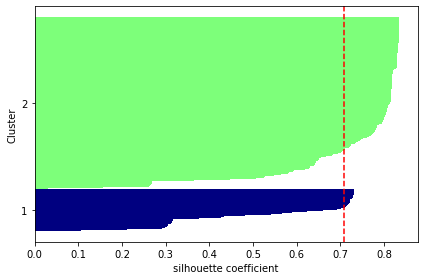

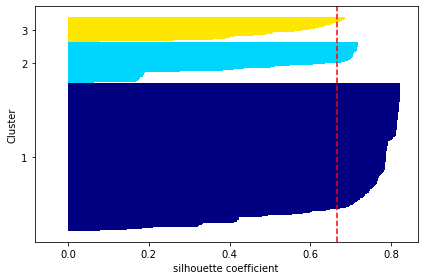

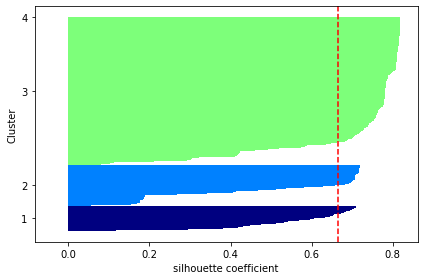

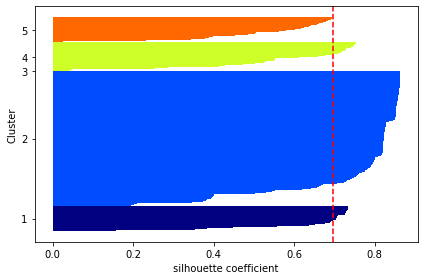

In [23]:
for i in range(2,6):
    plot_silhouette(i, df_pca.iloc[:10000, :])

#### ③ カーネルPCA後のデータ

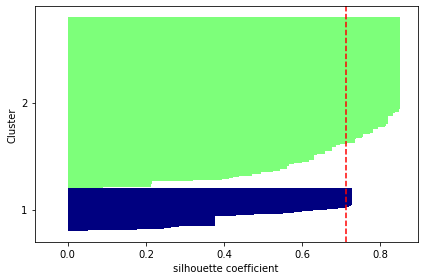

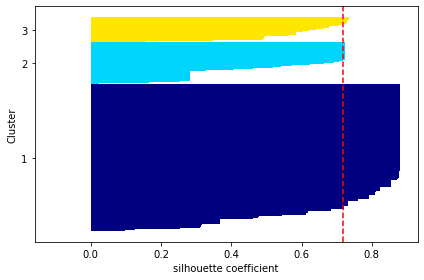

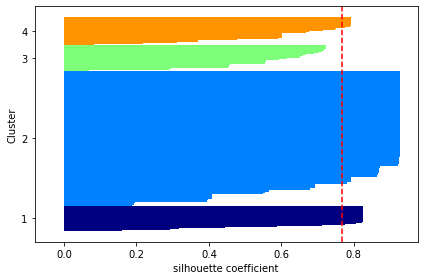

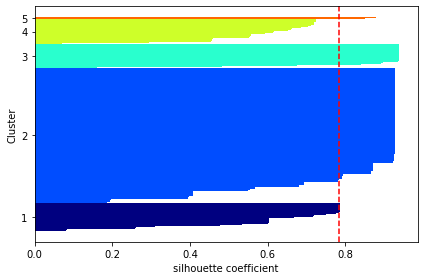

In [24]:
for i in range(2,6):
    plot_silhouette(i, df_kpca.iloc[:10000, :])

### クラスタリング・決定木分析

* ●次回の分析で挑戦したいこと
* 予測クラスラベルを活用した特微量生成
* 予測クラスラベルを答えラベルとし、決定木による重要度分析を行うことで、クラスタリングの分割理由の検証

In [25]:
std_pred_cluster

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [26]:
pca_pred_cluster

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [27]:
kpca_pred_cluster

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

## 5.2 階層的クラスタリング

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
result1 = linkage(df_std.iloc[:5000, :], 
                  #metric = 'braycurtis', 
                  #metric = 'canberra', 
                  #metric = 'chebyshev', 
                  #metric = 'cityblock', 
                  #metric = 'correlation', 
                  #metric = 'cosine', 
                  metric = 'euclidean', 
                  #metric = 'hamming', 
                  #metric = 'jaccard', 
                  #method= 'single')
                  #method = 'average')
                  method= 'complete')
                  #method = "ward")
                  #method='weighted')
dendrogram(result1)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

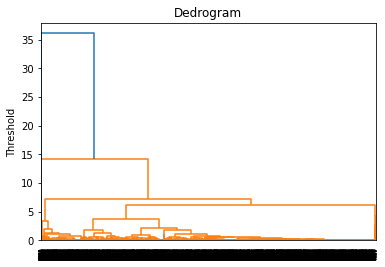

In [64]:
from scipy.cluster.hierarchy import linkage, dendrogram
result1 = linkage(df_pca.iloc[:5000, :], 
                  #metric = 'braycurtis', 
                  #metric = 'canberra', 
                  #metric = 'chebyshev', 
                  #metric = 'cityblock', 
                  #metric = 'correlation', 
                  #metric = 'cosine', 
                  metric = 'euclidean', 
                  #metric = 'hamming', 
                  #metric = 'jaccard', 
                  #method= 'single')
                  #method = 'average')
                  method= 'complete')
                  #method = "ward")
                  #method='weighted')
dendrogram(result1)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

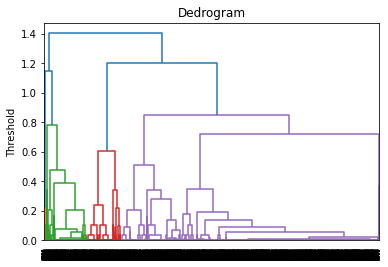

In [65]:
from scipy.cluster.hierarchy import linkage, dendrogram
result1 = linkage(df_kpca.iloc[:5000, :], 
                  #metric = 'braycurtis', 
                  #metric = 'canberra', 
                  #metric = 'chebyshev', 
                  #metric = 'cityblock', 
                  #metric = 'correlation', 
                  #metric = 'cosine', 
                  metric = 'euclidean', 
                  #metric = 'hamming', 
                  #metric = 'jaccard', 
                  #method= 'single')
                  #method = 'average')
                  method= 'complete')
                  #method = "ward")
                  #method='weighted')
dendrogram(result1)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

# 6.モデル作成

In [28]:
def evaluate_model_performnce(y_test, y_pred):
    """
    分類タスクの精度評価関数
    """
    cm = confusion_matrix(y_test, y_pred)
    
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax , fmt="g")
    
    # labels, title and ticks
    ax.set_xlabel("Predicted labels"); ax.set_ylabel("True labels");
    ax.set_title("Confusion Matrix");
    
    tn, fp, fn, tp = cm.ravel()
    
    # 正確性(陽性だと予測した対象の中で、実際に陽性だった割合)
    precision = tp / (tp + fp)
    # 再現性(実際に陽性だった対象に対して、陽性だと予測した割合)
    recall = tp / (tp + fn)
    # F1 調和平均 (正確性と再現率)
    f1 = 2 * (precision * recall) / (precision + recall)
    # 精度
    accuracy = ((tp + tn) / (tp + fp + tn + fn))
    print("Precision : ",precision)
    print("Recall : ",recall)
    print("F1 Score : ",f1)
    print("Validation Accuracy : ",accuracy)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy Score : ", accuracy)
    
    # 偽陽性レート、真陽性レート
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    # AUC値を算出
    auc = metrics.auc(fpr, tpr)
    print("AUC Value : ", auc)
    
    return accuracy, auc, f1

## 6.0 データ別精度

## データ分割

### ① デフォルトデータ（標準化）

In [29]:
# データ分割
y = df_std["state"]
x = df_std.drop(labels = ["state"],axis = 1)
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.3)

In [ ]:
# #機械学習モデルをリストに格納
models = []

models.append(("ロジスティック回帰",LogisticRegression(random_state=0)))
models.append(("決定木", DecisionTreeClassifier(random_state=0)))
models.append(("k近傍法",KNeighborsClassifier()))
models.append(("サポートベクターマシン(線形)",LinearSVC(random_state=0)))
models.append(("XGBClassifier",XGBClassifier(random_state=0,verbose=0)))
models.append(("LGBMClassifier",LinearSVC(random_state=0,verbose=0)))
models.append(("CatBoostClassifier",CatBoostClassifier(random_state=0,verbose=0)))

names_jp = []
results = []
    
for name_jp, model in models:

    print(model.fit(train_x,train_y),"\n")
    
    kfold = KFold(n_splits=5, shuffle=True)
    result = cross_val_score(model,train_x.iloc[0:10000, :],train_y.iloc[0:10000], cv = kfold, scoring = "accuracy", verbose=True)
    names_jp.append(name_jp)
    results.append(result)
    

list_df = pd.DataFrame(columns=['識別子','スコア(平均)','標準偏差'])
 
for i in range(len(names_jp)):
    list_df = list_df.append(pd.Series( [names_jp[i],results[i].mean(),results[i].std()], index=list_df.columns ), ignore_index=True)

list_df

* 0	ロジスティック回帰	0.6401	0.013782
* 1 決定木	0.5974	0.007432
* 2	k近傍法	0.6122	0.009569
* 3	サポートベクターマシン(線形)	0.6425	0.015218
* 4	XGBClassifier	0.6437	0.008262
* 5	LGBMClassifier	0.6413	0.006585
* 6	CatBoostClassifier	0.6579	0.012733

### ②PCA後のデータ

In [49]:
# データ分割
y = df_std["state"]
x = df_pca
train_pca_x, val_pca_x, train_pca_y, val_pca_y = train_test_split(x, y, test_size=0.3)

In [ ]:
# #機械学習モデルをリストに格納
models = []

models.append(("ロジスティック回帰",LogisticRegression(random_state=0)))
models.append(("決定木", DecisionTreeClassifier(random_state=0)))
models.append(("k近傍法",KNeighborsClassifier()))
models.append(("サポートベクターマシン(線形)",LinearSVC(random_state=0)))
models.append(("XGBClassifier",XGBClassifier(random_state=0)))
models.append(("LGBMClassifier",LinearSVC(random_state=0)))
models.append(("CatBoostClassifier",CatBoostClassifier(random_state=0)))

names_jp = []
results = []
    
for name_jp, model in models:

    print(model.fit(train_x,train_y),"\n")
    
    kfold = KFold(n_splits=5, shuffle=True)
    result = cross_val_score(model,train_pca_x.iloc[0:10000, :],train_pca_y.iloc[0:10000], cv = kfold, scoring = "accuracy", verbose=True)
    names_jp.append(name_jp)
    results.append(result)
    

list_df = pd.DataFrame(columns=['識別子','スコア(平均)','標準偏差'])
 
for i in range(len(names_jp)):
    list_df = list_df.append(pd.Series( [names_jp[i],results[i].mean(),results[i].std()], index=list_df.columns ), ignore_index=True)

list_df

* 識別子	スコア(平均)	標準偏差
* 0	ロジスティック回帰	0.6012	0.004567
* 1	決定木	0.5966	0.006320
* 2	k近傍法	0.6059	0.008840
* 3	サポートベクターマシン(線形)	0.6043	0.004665
* 4	XGBClassifier	0.6404	0.004317
* 5	LGBMClassifier	0.6055	0.006971
* 6	CatBoostClassifier	0.6423	0.013037

### ③カーネルPCA後のデータ

In [50]:
# データ分割
y = df_std["state"].iloc[:len(df_kpca)]
x = df_kpca
train_kpca_x, val_kpca_x, train_kpca_y, val_kpca_y = train_test_split(x, y, test_size=0.3)

In [ ]:
# #機械学習モデルをリストに格納
models = []

models.append(("ロジスティック回帰",LogisticRegression(random_state=0)))
models.append(("決定木", DecisionTreeClassifier(random_state=0)))
models.append(("k近傍法",KNeighborsClassifier()))
models.append(("サポートベクターマシン(線形)",LinearSVC(random_state=0)))
models.append(("XGBClassifier",XGBClassifier(random_state=0)))
models.append(("LGBMClassifier",LinearSVC(random_state=0)))
models.append(("CatBoostClassifier",CatBoostClassifier(random_state=0)))

names_jp = []
results = []
    
for name_jp, model in models:

    print(model.fit(train_x,train_y),"\n")
    
    kfold = KFold(n_splits=5, shuffle=True)
    result = cross_val_score(model,train_kpca_x.iloc[0:10000, :],train_kpca_y.iloc[0:10000], cv = kfold, scoring = "accuracy",verbose=True)
    names_jp.append(name_jp)
    results.append(result)
    

list_df = pd.DataFrame(columns=['識別子','スコア(平均)','標準偏差'])
 
for i in range(len(names_jp)):
    list_df = list_df.append(pd.Series( [names_jp[i],results[i].mean(),results[i].std()], index=list_df.columns ), ignore_index=True)

list_df

* 	識別子	スコア(平均)	標準偏差
* 0	ロジスティック回帰	0.6003	0.006735
* 1	決定木	0.5989	0.010892
* 2	k近傍法	0.5992	0.006577
* 3	サポートベクターマシン(線形)	0.5994	0.016530
* 4	XGBClassifier	0.6252	0.002993
* 5	LGBMClassifier	0.6018	0.009207
* 6	CatBoostClassifier	0.6288	0.011245


In [ ]:
df_std.to_csv("../working/df_std_good.csv")

## 6.1　デフォルトデータ（標準化）

### ① K-近傍法

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

list_nn = []
list_score = []
for k in range(10, 100, 10):
  # KNeighborsClassifier
  knc = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
  knc.fit(train_x, train_y)

  # 予測　
  Y_pred = knc.predict(val_x)

  # 評価 R^2
  score = knc.score(val_x, val_y)
  print("[%d] score: {:.2f}".format(score) % k)

  list_nn.append(k)
  list_score.append(score)

# プロット
plt.ylim(0.5, 0.7)
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.plot(list_nn, list_score)

* n_neighbors[10] score: 0.62
* n_neighbors[20] score: 0.63
* n_neighbors[30] score: 0.63
* n_neighbors[40] score: 0.64
* n_neighbors[50] score: 0.64
* n_neighbors[60] score: 0.64
* n_neighbors[70] score: 0.64
* n_neighbors[80] score: 0.64
* n_neighbors[90] score: 0.64

### ② 決定木

#### ① XGBClassifier

In [ ]:
import optuna
import sklearn

def objective(trial):

    # パラメータ種類 & 探索範囲
    n_estimators = trial.suggest_int('n_estimators', 4, 10000)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    alpha = int(trial.suggest_int("max_leaf_nodes", 2, 11))
    
    clf = XGBClassifier(
        random_state=0,
        n_estimators = n_estimators,
        max_depth = max_depth,
        subsample = subsample,
        alpha = alpha,
        colsample_bytree = colsample_bytree,
        min_child_weight = min_child_weight
    )
    
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
        clf, train_x.iloc[0:10000, :],  train_y.iloc[0:10000], n_jobs=-1, cv=skf ,verbose=True).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[08:44:18] WARNING: ../src/learner.cc:541: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Precision :  0.6139488847255117
Recall :  0.43244858323788654
F1 Score :  0.5074578895852506
Validation Accuracy :  0.6611659949951257
Accuracy Score :  0.6611659949951257
AUC Value :  0.6242052828391789


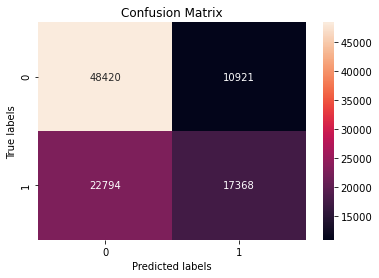

In [58]:
xgb_clf = XGBClassifier(**{'n_estimators': 49, 'max_depth': 2, 'subsample': 0.6, 'min_child_weight': 19, 'colsample_bytree': 0.7, 'max_leaf_nodes': 2})
xgb_clf.fit(train_x, train_y, eval_metric=["auc", "logloss"],verbose = True)

threshold = 0.5
xgb_val_prob = xgb_clf.predict_proba(val_x)
xgb_val_prob = pd.DataFrame(xgb_val_prob)[1]
xgb_val_pred = [ 1 if x >= threshold else 0 for x in xgb_val_prob]
xgb_acc, xgb_auc, xgb_f1 = evaluate_model_performnce(val_y, xgb_val_pred)

*  acuuracy :  0.6668000000000001 
* parameters: {'n_estimators': 77, 'max_depth': 3.3666868069814213, 'subsample': 0.6, 'min_child_weight': 19, 'colsample_bytree': 0.8, 'max_leaf_nodes': 6}

#### 重要度

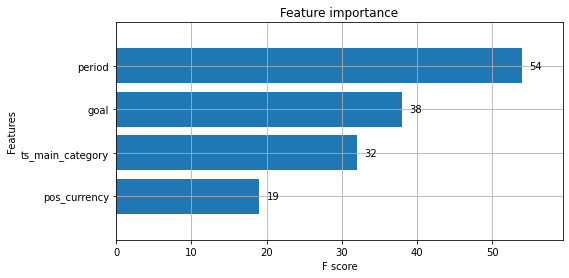

In [59]:
_, ax = plt.subplots(figsize = (8, 4))
xgb.plot_importance(xgb_clf, height = 0.8, ax = ax)
plt.show()

#### 寄与度

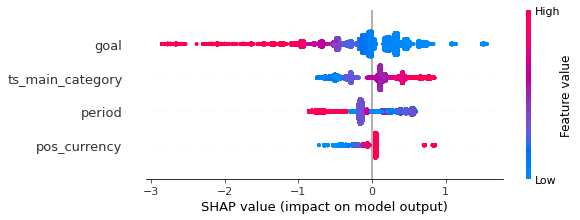

In [60]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model = xgb_clf)
shap_values = explainer.shap_values(X = train_x)
shap.summary_plot(shap_values, train_x)

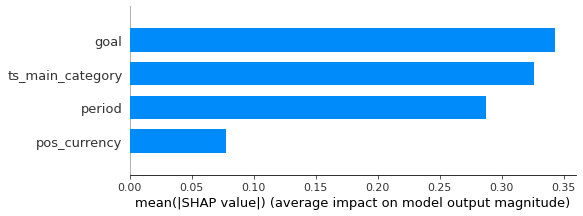

In [61]:
shap.summary_plot(shap_values, train_x, plot_type = "bar")

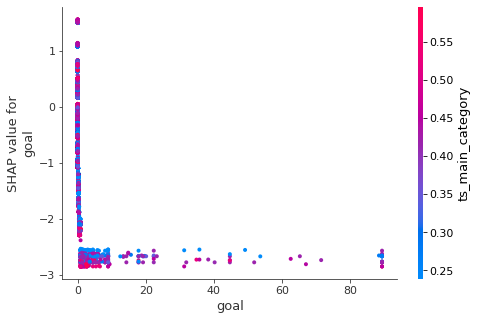

In [62]:
shap.dependence_plot(ind = "goal", shap_values = shap_values, features = train_x)

#### ② LGBMClassifier

In [ ]:
import lightgbm as lgb

# 特微量と目的変数をlightgbmのデータ構造に変換
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(val_x, val_y)

In [31]:
import optuna
import sklearn

def objective(trial):

    # パラメータ種類 & 探索範囲
    n_estimators = trial.suggest_int('n_estimators', 1, 10000)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    max_bin = trial.suggest_int('max_bin', 100, 350)
    num_leaves = trial.suggest_int('num_leaves', 2, 256)
    learning_rate = trial.suggest_int('learning_rate', 0.01, 100)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    # alpha = int(trial.suggest_int("max_leaf_nodes", 2, 11))
    
    clf = LGBMClassifier(
        random_state=0,
        n_estimators = n_estimators,
        max_depth = max_depth,
        # max_bin = max_bin,
        num_leaves = num_leaves,
        #learning_rate = learning_rate,
        subsample = subsample,
        # alpha = alpha,
        colsample_bytree = colsample_bytree,
        min_child_weight = min_child_weight
    )
    
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
        clf, train_x.iloc[0:10000, :],  train_y.iloc[0:10000], n_jobs=-1, cv=skf, verbose=True).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-04-06 01:27:39,760] A new study created in memory with name: no-name-2f0537ed-be05-4ee4-a2b1-7dab602f1981
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s finished
[I 2021-04-06 01:28:11,283] Trial 0 finished with value: 0.6067 and parameters: {'n_estimators': 7396, 'max_depth': 7.084394052664247, 'max_bin': 165, 'num_leaves': 250, 'learning_rate': 89, 'subsample': 0.8, 'min_child_weight': 10, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.6067.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished
[I 2021-04-06 01:28:19,898] Trial 1 finished with value: 0.6580999999999999 and parameters: {'n_estimators': 6214, 'max_depth': 1.419493998316856, 'max_bin': 209, 'num_leaves': 125, 'learning_rate': 65, 'subsample': 0.9, 'min_child_weight': 1, 'colsample_bytree': 0.9}. Best is trial 1 with value:

Accuracy: 0.6605000000000001
Best hyperparameters: {'n_estimators': 330, 'max_depth': 2.823259943703751, 'max_bin': 329, 'num_leaves': 14, 'learning_rate': 23, 'subsample': 0.8, 'min_child_weight': 18, 'colsample_bytree': 0.7}


In [ ]:
clf = LGBMClassifier(**{'n_estimators': 87, 'max_depth': 11,'subsample': 0.8, 'min_child_weight': 8, 'colsample_bytree': 0.7, 'max_leaf_nodes': 8})
clf.fit(train_x, train_y, eval_metric=["auc", "logloss"],verbose = True)

threshold = 0.5
lgb_val_prob = clf.predict_proba(val_x)
val_prob = clf.predict_proba(val_x)
val_prob = pd.DataFrame(val_prob)[1]
val_pred = [ 1 if x >= threshold else 0 for x in val_prob]
acc, auc, f1 = evaluate_model_performnce(val_y, val_pred)

* Accuracy: 0.6662689585696819
* Best hyperparameters: {'n_estimators': 272, 'max_depth': 5.097382362721678, 'max_bin': 158, 'num_leaves': 154, 'learning_rate': 14, 'subsample': 0.7, 'min_child_weight': 3, 'colsample_bytree': 0.9}

#### ③ CatBoostClassifier

In [33]:
import optuna
import sklearn

def objective(trial):

    # パラメータ種類 & 探索範囲
    n_estimators = trial.suggest_int('n_estimators', 5, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    
    clf = CatBoostClassifier(
        random_state=0,
        n_estimators = n_estimators,
        max_depth = max_depth,
        subsample = subsample
    )
    
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
        clf, train_x.iloc[0:20000, :], train_y.iloc[0:20000], n_jobs=-1, cv=skf, verbose=True).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-04-06 02:14:41,869] A new study created in memory with name: no-name-dfd65f5a-67e0-4438-a4ad-879af663178c
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.5s finished
[I 2021-04-06 02:14:57,390] Trial 0 finished with value: 0.65695 and parameters: {'n_estimators': 403, 'max_depth': 1, 'subsample': 0.8}. Best is trial 0 with value: 0.65695.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[I 2021-04-06 02:15:57,565] Trial 1 finished with value: 0.6517999999999999 and parameters: {'n_estimators': 735, 'max_depth': 8, 'subsample': 0.9}. Best is trial 0 with value: 0.65695.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished
[I 2021-04-06 02:20:29,420] Trial 2 finished with value: 0.63735 and parameters: {'n

Accuracy: 0.6572500000000001
Best hyperparameters: {'n_estimators': 252, 'max_depth': 4, 'subsample': 0.7}


* Accuracy: 0.66252
* Best hyperparameters: {'n_estimators': 86, 'max_depth': 8, 'subsample': 0.5}

In [ ]:
clf = CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8})
clf.fit(train_x, train_y, verbose=True)

threshold = 0.5
cat_val_prob = clf.predict_proba(val_x)
cat_val_prob = pd.DataFrame(cat_val_prob)[1]
cat_val_pred = [ 1 if x >= threshold else 0 for x in cat_val_prob]
acc, auc, f1 = evaluate_model_performnce(val_y, cat_val_pred)

*  Accuracy: 0.6652783345732443
* Best hyperparameters: {'n_estimators': 100, 'max_depth': 6.323489231787944, 'subsample': 0.8}

* Accuracy: 0.6635382434180677
* Best hyperparameters: {'n_estimators': 83, 'max_depth': 11.042407051365212, 'subsample': 0.8}

* Accuracy: 0.66356
* Best hyperparameters: {'n_estimators': 70, 'max_depth': 2, 'subsample': 0.5}

### ③ ロジスティック回帰

In [ ]:
# パラメータ候補の全組み合わせを試し、平均的に優れた性能を示すパラメータ探索
from sklearn.model_selection import GridSearchCV

# グリッドサーチ(LogisticRegressionのパラメーター）
parameters = [
    {'solver': ['liblinear', 'saga'], 'penalty':['l1', 'l2'], 'C': [0.1, 1, 10, 100], "random_state":[0]},
    {'solver': ['newton-cg', 'sag', 'lbfgs' ], 'penalty':['l2'], 'C': [0.1, 1, 10, 100],"random_state":[0]},
]

#グリッドサーチ実行
classifier = GridSearchCV(LogisticRegression(), parameters, cv=3, n_jobs=-1)
classifier.fit(train_x, train_y)
print("Accuracy score (train): ", classifier.score(train_x.iloc[0:10000, :], train_y.iloc[0:10000]))
print("Accuracy score (test): ", classifier.score(val_x.iloc[0:10000, :], val_y.iloc[0:10000]))
print('best params: {}'.format(classifier.best_estimator_)) 
print('best val score:  {:0.3f}'.format(classifier.best_score_))
lr_val_pred = classifier.predict(val_x)

* Accuracy score (train):  0.6469
* Accuracy score (test):  0.658
* best params: LogisticRegression(C=100, random_state=0, solver='liblinear')
* best val score:  0.642

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
degrees = np.arange(1,4)#degreeの値を4つ指定する

for degree in degrees:
    est = make_pipeline(PolynomialFeatures(degree), classifier.best_estimator_)
    est.fit(train_x, train_y)
    print("degree: {} / score :{}".format(degree, est.score(val_x, val_y)))

* degree: 1 / score :0.64257359074600767
* degree: 2 / score :0.64269419012492091
* degree: 3 / score :0.6412871973709335

In [ ]:
# k分割交差検証の実行(最適な組み合わせ)
scores = cross_val_score(make_pipeline(PolynomialFeatures(3),
                                       classifier.best_estimator_),
                                       train_x.iloc[0:5000, :], train_y.iloc[0:5000])

#結果表示
print('Cross validation scores : {}'.format(scores))
print('Cross validation scores : {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

* degrees 3:
* Cross validation scores : [0.635 0.666 0.665 0.623 0.653]
* Cross validation scores : 0.648+-0.017

### ④ SVC

In [ ]:
import optuna
import sklearn

def objective(trial):
#目的関数
    params = {
        'kernel': trial.suggest_categorical('kernel', ['linear','rbf','sigmoid']),
        'C': trial.suggest_loguniform('C', 1e+0, 1e+2/2),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 3.0),
    }
    clf = SVC(**params)
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
    clf, train_x.iloc[0:2000, :],  train_y.iloc[0:2000], n_jobs=-1, cv=skf, verbose=True).mean()

#セッション作成
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Accuracy: 0.6525000000000001
* Best hyperparameters: {'kernel': 'linear', 'C': 30.850303956144966, 'gamma': 2.712344584243453}

In [ ]:
clf = SVC(**{'C': 1000, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 0})
clf.fit(train_x.iloc[0:2000, :],train_y.iloc[0:2000])
score = clf.score(val_x.iloc[0:2000, :], val_y.iloc[0:2000])
print(score)

In [ ]:
clf = SVC(**trial.params, probability=True)
clf.fit(train_x.iloc[0:10000, :],  train_y.iloc[0:10000])

threshold = 0.5
svc_val_prob = clf.predict_proba(val_x)
svc_val_prob = pd.DataFrame(svc_val_prob)[1]
svc_val_pred = [ 1 if x >= threshold else 0 for x in svc_val_prob]
acc, auc, f1 = evaluate_model_performnce(val_y, svc_val_pred)

### ⑤ Neural Network

In [56]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam

model = Sequential()

model.add(Dense(6, activation="relu", input_dim=4)) # 第1層
model.add(Dense(5, activation="tanh", input_dim=6)) # 第2層
model.add(Dense(7, activation="relu", input_dim=6)) # 第3層
model.add(Dense(3, activation="tanh", input_dim=6)) # 第4層
model.add(Dense(7, activation="relu", input_dim=6)) # 第5層
model.add(Dense(3, activation="tanh", input_dim=6)) # 第6層
model.add(Dense(7, activation="relu", input_dim=6)) # 第7層
model.add(Dense(3, activation="tanh", input_dim=6)) # 第8層
model.add(Dense(1, activation="sigmoid"))           # 第9層

# 最適化手法
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
#rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)

model.compile(loss="binary_crossentropy",
             optimizer=adam,
             metrics=["accuracy"])

# 計算の実行
fit = model.fit(train_x, train_y,
    epochs=1000,
    batch_size=100000, 
    validation_data=(val_x, val_y),verbose=True)

# 各epochにおける損失と精度をdf化
nn_df = pd.DataFrame(fit.history)

Epoch 1/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.6923 - accuracy: 0.5274 - val_loss: 0.6807 - val_accuracy: 0.5964
Epoch 2/1000
3/3 [==============================] - 0s 77ms/step - loss: 0.6790 - accuracy: 0.5965 - val_loss: 0.6733 - val_accuracy: 0.5964
Epoch 3/1000
3/3 [==============================] - 0s 72ms/step - loss: 0.6733 - accuracy: 0.5957 - val_loss: 0.6730 - val_accuracy: 0.5964
Epoch 4/1000
3/3 [==============================] - 0s 71ms/step - loss: 0.6725 - accuracy: 0.5958 - val_loss: 0.6716 - val_accuracy: 0.5964
Epoch 5/1000
3/3 [==============================] - 0s 73ms/step - loss: 0.6713 - accuracy: 0.5961 - val_loss: 0.6709 - val_accuracy: 0.5964
Epoch 6/1000
3/3 [==============================] - 0s 73ms/step - loss: 0.6703 - accuracy: 0.5960 - val_loss: 0.6694 - val_accuracy: 0.5964
Epoch 7/1000
3/3 [==============================] - 0s 74ms/step - loss: 0.6686 - accuracy: 0.5961 - val_loss: 0.6673 - val_accuracy: 0.6018
Epoch 8/1000

In [ ]:
# グラフ化
nn_df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

nn_df[["accuracy", "val_accuracy"]].plot()
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim([0.65, 0.70])
plt.show()

### ⑥ アンサンブル学習

#### ① StackingClassifier

In [47]:
from sklearn.ensemble import StackingClassifier


# 1段目として、二つのモデルを構築。
estimators = [
        ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=100, n_jobs=-1)),
        ('LogisticRegression', make_pipeline(PolynomialFeatures(3),LogisticRegression(C=100, random_state=0, solver='liblinear'))),
        #('SVC', SVC(**{'kernel': 'linear', 'C': 30.850303956144966, 'gamma': 2.712344584243453})),
        ('XGB', XGBClassifier(**{'n_estimators': 77, 'max_depth': 3, 'subsample': 0.6, 'min_child_weight': 19, 'colsample_bytree': 0.8, 'max_leaf_nodes': 6, 'silent':1})),
        ('LGBMClassifier', LGBMClassifier()),
        ('CatBoostClassifier', CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8, 'silent':True}))
        ]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8, 'silent':True}),
)
clf.fit(train_x.iloc[0:300000, :],  train_y.iloc[0:300000])
print("正解率:", clf.score(val_x.iloc[0:300000, :], val_y.iloc[0:300000]))

[07:08:57] WARNING: ../src/learner.cc:541: 
Parameters: { max_leaf_nodes, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:08:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:10:18] WARNING: ../src/learner.cc:541: 
Parameters: { max_leaf_nodes, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:10:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 

* 正解率: 0.6656382219631569

#### ② 多数決アンサンブル

In [35]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
  """
  多数決アンサンブル分類器
  パラメータ------------------
  classfiers : array-like アンサンブルの様々な学習器
  vote : str, {"classlabel, "probability} (defualt : "classlabel")
    "classlabel"の場合、クラスラベルの予測はクラスラベルのargmaxに基づく
    "probability"の場合、クラスラベルの予測はクラスの所属確率のargmaxに基づく（分類器が調整済みであることが推奨）
  weights : array-like (optional, defualt=None)
    int または float 型の値のリストが提供された場合、分類器は重要度で重み付けされる.
    weights-None の場合、均一の重みを使用.

  BaseEstimator------------------
    set_params : 分類器のパラメータを設定
    get_params : パラメータを取得
  ClassifierMixin------------------

  """
  def __init__(self, classifiers, vote="classlabel", weights=None):

    self.classifiers = classifiers
    self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
    self.vote = vote
    self.weights = weights

  def fit(self, X, y):
    """
    分類器学習.

    パラメータ------------------
    X : 訓練データからなる行列
    y : クラスラベルのベクトル
    """
    if self.vote not in ('probability', 'classlabel'):
        raise ValueError("vote must be 'probability' or 'classlabel'"
                         "; got (vote=%r)"
                         % self.vote)

    if self.weights and len(self.weights) != len(self.classifiers):
        raise ValueError('Number of classifiers and weights must be equal'
                         '; got %d weights, %d classifiers'
                         % (len(self.weights), len(self.classifiers)))
    # Labelエンコーディング
    self.lablenc_ = LabelEncoder()
    self.lablenc_.fit(y)
    self.classes_ = self.lablenc_.classes_
    self.classifiers_ = []
    # 各分類器で学習
    for clf in self.classifiers:
        fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
        self.classifiers_.append(fitted_clf)
    return self

  def predict(self, X):
    """ X のクラスラベルを予測.
    X : 訓練データからなる行列
    戻り値 : 予測されたクラスラベル
    """

    if self.vote == "probability":
      maj_vote = np.argmax(self.predict_proba(X), axis=1)
    else : 
      # classラベルでの多数決

      # clf.predictで各分類器の予測結果を収集
      predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T

      # 各データ点のクラス確率に重みをかけて足し合わせた値が最大となる
      # 列番号を配列として返す (行単位で関数を適用)
      maj_vote = np.apply_along_axis(
          lambda x: np.argmax(np.bincount(x, weights=self.weights)), # np.bincount : 最頻値
          axis=1,
          arr = predictions
      )
    # 各データ点に確率の最大値を与えるクラスラベルを抽出
    maj_vote = self.lablenc_.inverse_transform(maj_vote)
    return maj_vote
  
  def predict_proba(self, X):
    """
    X のクラス確率を予測

    X : 訓練ベクトル（n_examplesはデータ点の個数, n_featuresは特微量の個数)
    avg_proba : 各データ点に対する各クラスで重み付けた平均確率

    """
    probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
    avg_proba = np.average(probas, axis=0, weights=self.weights)
    return avg_proba

  def get_params(self, deep=True):
    """
    GridSeachの実行時に分類器のパラメータ名を取得
    """
    if not deep:
        return super(MajorityVoteClassifier, self).get_params(deep=False)
    else:
        # キーを分類器の名前_パラメータ名
        # 値をパラメータの値とするディクショナリを生成
        out = self.named_classifiers.copy()
        for name, step in self.named_classifiers.items():
            for key, value in step.get_params(deep=True).items():
                out['%s__%s' % (name, key)] = value
        return out

In [44]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# アンサンブル学習に使うベース分類器
clf1 = make_pipeline(PolynomialFeatures(3),LogisticRegression(C=100, random_state=0, solver='liblinear'))
clf2 = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
#clf3 = SVC(**{'kernel': 'linear', 'C': 30.850303956144966, 'gamma': 2.712344584243453})
clf4 = xgb_clf = XGBClassifier(**{'n_estimators': 77, 'max_depth': 3, 'subsample': 0.6, 'min_child_weight': 19, 'colsample_bytree': 0.8, 'silent':1})
clf5 = LGBMClassifier(**{ 'silent':1})
clf6 = CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8,  'silent':True})

# 分類器ラベル
clf_labels = []
clf_labels = ['Logistic regression', 'KNeighborsClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']

print('10-fold cross validation:\n')

list_df = pd.DataFrame()
mv_clf = MajorityVoteClassifier(classifiers=[clf1, clf2, clf4, clf5, clf6], weights=[0.05,0.05,0.3,0.3,0.3])

clf_labels += ['Majority voting']
all_clf = [clf1, clf2, clf4, clf5, clf6, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=train_x.iloc[0:300000,:], 
                             y=train_y.iloc[0:300000],
                             cv=3,
                             scoring='accuracy',
                             verbose=True)
    print("accuracy: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))
    list_df = list_df.append(pd.Series( [scores.mean(), scores.std(),label] ), ignore_index=True)
list_df.columns = ['スコア(平均)', "標準偏差", "識別子"]

10-fold cross validation:



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.639 (+/- 0.000) [Logistic regression]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.657 (+/- 0.001) [KNeighborsClassifier]
[06:54:00] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:54:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:54:02] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:54:02] WARNING: ../src/learner.cc:1061: S

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.665 (+/- 0.001) [XGBClassifier]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.666 (+/- 0.000) [LGBMClassifier]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.666 (+/- 0.001) [CatBoostClassifier]
[06:54:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:54:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:54:47] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:54:47] WARNING: ../src/learner.cc:1061: Sta

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished


* accuracy: 0.666 (+/- 0.001) [CatBoostClassifier]
* accuracy: 0.666 (+/- 0.001) [Majority voting]

## 6.2 PCA後のデータ

### ① K-近傍法

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

list_nn = []
list_score = []
for k in range(10, 100, 10):
  # KNeighborsClassifier
  knc = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
  knc.fit(train_pca_x, train_pca_y)

  # 予測　
  Y_pred = knc.predict(val_pca_x)

  # 評価 R^2
  score = knc.score(val_pca_x, val_pca_y)
  print("[%d] score: {:.2f}".format(score) % k)

  list_nn.append(k)
  list_score.append(score)

# プロット
plt.ylim(0.5, 0.65)
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.plot(list_nn, list_score)


* [10] score: 0.64
* [20] score: 0.65
* [30] score: 0.65
* [40] score: 0.65
* [50] score: 0.65
* [60] score: 0.66
* [70] score: 0.66
* [80] score: 0.66
* [90] score: 0.66

### ② 決定木

#### ①XGBClassifier

In [ ]:
import optuna
import sklearn

def objective(trial):

    # パラメータ種類 & 探索範囲
    n_estimators = trial.suggest_int('n_estimators', 4, 100)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    alpha = int(trial.suggest_int("max_leaf_nodes", 2, 11))
    
    clf = XGBClassifier(
        random_state=0,
        n_estimators = n_estimators,
        max_depth = max_depth,
        subsample = subsample,
        alpha = alpha,
        colsample_bytree = colsample_bytree,
        min_child_weight = min_child_weight
    )
    
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
         clf, train_pca_x.iloc[0:5000, :],  train_pca_y.iloc[0:5000], n_jobs=-1, cv=skf, verbose=True).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Accuracy: 0.6554
* Best hyperparameters: {'n_estimators': 27, 'max_depth': 3.309631352719992, 'subsample': 0.7, 'min_child_weight': 19, 'colsample_bytree': 0.7, 'max_leaf_nodes': 3}

#### ② LGBMClassifier

In [ ]:
import optuna
import sklearn

def objective(trial):

    # パラメータ種類 & 探索範囲
    n_estimators = trial.suggest_int('n_estimators', 4, 100)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    alpha = int(trial.suggest_int("max_leaf_nodes", 2, 11))
    
    clf = LGBMClassifier(
        random_state=0,
        n_estimators = n_estimators,
        max_depth = max_depth,
        subsample = subsample,
        alpha = alpha,
        colsample_bytree = colsample_bytree,
        min_child_weight = min_child_weight
    )
    
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
        clf, train_pca_x.iloc[0:5000, :],  train_pca_y.iloc[0:5000], n_jobs=-1, cv=skf, verbose=True).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Accuracy: 0.6542
* Best hyperparameters: {'n_estimators': 88, 'max_depth': 2.7556225893453057, 'subsample': 0.5, 'min_child_weight': 6, 'colsample_bytree': 0.9, 'max_leaf_nodes': 3}

#### ③ CatBoostClassifier

In [ ]:
import optuna
import sklearn

def objective(trial):

    # パラメータ種類 & 探索範囲
    n_estimators = trial.suggest_int('n_estimators', 4, 100)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    
    clf = CatBoostClassifier(
        random_state=0,
        n_estimators = n_estimators,
        max_depth = max_depth,
        subsample = subsample
    )
    
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
        clf, train_pca_x.iloc[0:5000, :],  train_pca_y.iloc[0:5000], n_jobs=-1, cv=skf, verbose=True).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Accuracy: 0.651
* Best hyperparameters: {'n_estimators': 71, 'max_depth': 5.933306918280549, 'subsample': 0.8}

### ③ ロジスティック回帰

In [ ]:
# パラメータ候補の全組み合わせを試し、平均的に優れた性能を示すパラメータ探索
from sklearn.model_selection import GridSearchCV

# グリッドサーチ(LogisticRegressionのパラメーター）
parameters = [
    {'solver': ['liblinear', 'saga'], 'penalty':['l1', 'l2'], 'C': [0.1, 1, 10, 100], "random_state":[0]},
    {'solver': ['newton-cg', 'sag', 'lbfgs' ], 'penalty':['l2'], 'C': [0.1, 1, 10, 100],"random_state":[0]},
]

#グリッドサーチ実行
classifier = GridSearchCV(LogisticRegression(), parameters, cv=3, n_jobs=-1)
classifier.fit(train_pca_x.iloc[0:5000, :],  train_pca_y.iloc[0:5000])
print("Accuracy score (train): ", classifier.score(train_pca_x.iloc[0:5000, :],  train_pca_y.iloc[0:5000]))
print("Accuracy score (test): ", classifier.score(val_pca_x.iloc[0:5000, :], val_pca_y.iloc[0:5000]))
print('best params: {}'.format(classifier.best_estimator_)) 
print('best val score:  {:0.3f}'.format(classifier.best_score_))
lr_val_pred = classifier.predict(val_pca_x.iloc[0:5000, :])

* Accuracy score (train):  0.6478
* Accuracy score (test):  0.651
* best params: LogisticRegression(C=10, penalty='l1', random_state=0, solver='liblinear')
* best val score:  0.647

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
degrees = np.arange(1,4)#degreeの値を4つ指定する

for degree in degrees:
    est = make_pipeline(PolynomialFeatures(degree), classifier.best_estimator_)
    est.fit( train_pca_x,  train_pca_y,)
    print("degree: {} / score :{}".format(degree, est.score(val_pca_x, val_pca_y)))

* degree: 1 / score :0.6396591057556054
* degree: 2 / score :0.6412168477332342
* degree: 3 / score :0.640664100579882

In [ ]:
# k分割交差検証の実行(最適な組み合わせ)
scores = cross_val_score(make_pipeline(PolynomialFeatures(2),
                                       classifier.best_estimator_),
                                        train_pca_x,train_pca_y,)

#結果表示
print('Cross validation scores : {}'.format(scores))
print('Cross validation scores : {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

### ④ SVC

In [ ]:
import optuna
import sklearn

def objective(trial):
#目的関数
    params = {
        'kernel': trial.suggest_categorical('kernel', ['linear','rbf','sigmoid']),
        'C': trial.suggest_loguniform('C', 0.001, 1000),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1000),
    }
    clf = SVC(**params)
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
    clf, train_pca_x.iloc[0:2000, :],  train_pca_y.iloc[0:2000], n_jobs=-1, cv=skf, verbose=True).mean()

#セッション作成
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Accuracy: 0.635
* Best hyperparameters: {'kernel': 'linear', 'C': 306.07724319406384, 'gamma': 80.46475839426842}

In [ ]:
clf = SVC(**trial.params, probability=True)
clf.fit(train_pca_x.iloc[0:10000, :], train_pca_y.iloc[0:10000])

threshold = 0.5
svc_val_prob = clf.predict_proba(val_pca_x.iloc[0:10000, :])
svc_val_prob = pd.DataFrame(svc_val_prob)[1]
svc_val_pred = [ 1 if x >= threshold else 0 for x in svc_val_prob]
acc, auc, f1 = evaluate_model_performnce(val_y.iloc[0:10000], svc_val_pred)

### ⑤ Neural Network

In [ ]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam

model = Sequential()

model.add(Dense(6, activation="relu", input_dim=3)) # 第1層
model.add(Dense(32, activation="tanh", input_dim=6)) # 第2層
model.add(Dense(12, activation="relu", input_dim=6)) # 第3層
model.add(Dense(3, activation="tanh", input_dim=6)) # 第4層
model.add(Dense(7, activation="relu", input_dim=6)) # 第5層
model.add(Dense(3, activation="tanh", input_dim=6)) # 第6層
model.add(Dense(1, activation="sigmoid"))           # 第7層

# 最適化手法
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)

model.compile(loss="binary_crossentropy",
             optimizer=adam,
             metrics=["accuracy"])

# 計算の実行
fit = model.fit(train_pca_x, train_pca_y,
    epochs=1000,
    batch_size=200000, 
    validation_data=(val_pca_x, val_pca_y),verbose=True)

# 各epochにおける損失と精度をdf化
nn_df = pd.DataFrame(fit.history)
nn_df

In [ ]:
# グラフ化
nn_df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

nn_df[["accuracy", "val_accuracy"]].plot()
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim([0.60, 0.70])
plt.show()

### ⑥ アンサンブル学習

#### ① StackingClassifier

In [51]:
from sklearn.ensemble import StackingClassifier


# 1段目として、二つのモデルを構築。
estimators = [
        ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=100, n_jobs=-1)),
        ('LogisticRegression', make_pipeline(PolynomialFeatures(3),LogisticRegression(C=100, random_state=0, solver='liblinear'))),
        #('SVC', SVC(**{'kernel': 'linear', 'C': 30.850303956144966, 'gamma': 2.712344584243453})),
        ('XGB', XGBClassifier(**{'n_estimators': 77, 'max_depth': 3, 'subsample': 0.6, 'min_child_weight': 19, 'colsample_bytree': 0.8, 'max_leaf_nodes': 6, 'silent':1})),
        ('LGBMClassifier', LGBMClassifier(**{'n_estimators': 272, 'max_depth': 5, 'max_bin': 158, 'num_leaves': 154, 'learning_rate': 14, 'subsample': 0.7, 'min_child_weight': 3, 'colsample_bytree': 0.9, 'silent':1})),
        ('CatBoostClassifier', CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8, 'silent':True}))
        ]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8, 'silent':True}),
)
clf.fit(train_pca_x.iloc[0:10000, :],  train_pca_y.iloc[0:10000])
print("正解率:", clf.score(val_pca_x.iloc[0:10000, :], val_pca_y.iloc[0:10000]))

[07:14:17] WARNING: ../src/learner.cc:541: 
Parameters: { max_leaf_nodes, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:14:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:14:19] WARNING: ../src/learner.cc:541: 
Parameters: { max_leaf_nodes, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:14:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 

* 正解率: 0.6485

#### ②多数決アンサンブル


In [53]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# アンサンブル学習に使うベース分類器
clf1 = make_pipeline(PolynomialFeatures(3),LogisticRegression(C=100, random_state=0, solver='liblinear'))
clf2 = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
clf3 = SVC(**{'kernel': 'linear', 'C': 30.850303956144966, 'gamma': 2.712344584243453})
clf4 = xgb_clf = XGBClassifier(**{'n_estimators': 77, 'max_depth': 3, 'subsample': 0.6, 'min_child_weight': 19, 'colsample_bytree': 0.8, 'silent':1})
clf5 = LGBMClassifier(**{ 'silent':1})
clf6 = CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8,  'silent':True})

# 分類器ラベル
clf_labels = []
clf_labels = ['Logistic regression', 'KNeighborsClassifier','SVC', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']

print('10-fold cross validation:\n')

list_df = pd.DataFrame()
mv_clf = MajorityVoteClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5, clf6], weights=[0.025,0.1, 0.025,0.25,0.25,0.35])

clf_labels += ['Majority voting']
all_clf = [clf1, clf2, clf3, clf4, clf5, clf6, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=train_pca_x.iloc[0:10000,:], 
                             y=train_pca_y.iloc[0:10000],
                             cv=3,
                             scoring='accuracy',
                             verbose=True)
    print("accuracy: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))
    list_df = list_df.append(pd.Series( [scores.mean(), scores.std(),label] ), ignore_index=True)
list_df.columns = ['スコア(平均)', "標準偏差", "識別子"]

10-fold cross validation:



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.634 (+/- 0.007) [Logistic regression]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.624 (+/- 0.006) [KNeighborsClassifier]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.629 (+/- 0.007) [SVC]
[07:15:43] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:15:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:15:43] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:15:43] WARNING: ../src/learner.cc:1061: Starting in XGBoos

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.631 (+/- 0.009) [LGBMClassifier]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.637 (+/- 0.007) [CatBoostClassifier]
[07:15:49] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:15:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:15:54] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:15:54] WARNING: ../src/learner.cc:1061: Sta

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.8s finished


* accuracy: 0.635 (+/- 0.007) [Majority voting]

## 6.3 カーネルPCA後のデータ

### ① K-近傍法

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

list_nn = []
list_score = []
for k in range(10, 100, 10):
  # KNeighborsClassifier
  knc = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
  knc.fit(train_kpca_x.iloc[:10000,:], train_kpca_y.iloc[:10000])

  # 予測　
  Y_pred = knc.predict(val_kpca_x.iloc[:10000,:])

  # 評価 R^2
  score = knc.score(val_kpca_x.iloc[:10000,:], val_kpca_y.iloc[:10000])
  print("[%d] score: {:.2f}".format(score) % k)

  list_nn.append(k)
  list_score.append(score)

# プロット
plt.ylim(0.5, 0.65)
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.plot(list_nn, list_score)


* [10] score: 0.62
* [20] score: 0.63
* [30] score: 0.63
* [40] score: 0.63
* [50] score: 0.63
* [60] score: 0.63
* [70] score: 0.63
* [80] score: 0.63
* [90] score: 0.63

### ② 決定木

#### ① XGBClassifier

In [ ]:
import optuna
import sklearn

def objective(trial):

    # パラメータ種類 & 探索範囲
    n_estimators = trial.suggest_int('n_estimators', 4, 100)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    alpha = int(trial.suggest_int("max_leaf_nodes", 2, 11))
    
    clf = XGBClassifier(
        random_state=0,
        n_estimators = n_estimators,
        max_depth = max_depth,
        subsample = subsample,
        alpha = alpha,
        colsample_bytree = colsample_bytree,
        min_child_weight = min_child_weight
    )
    
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
         clf, train_kpca_x.iloc[:10000,:], train_kpca_y.iloc[:10000], n_jobs=-1, cv=skf, verbose=True).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Accuracy: 0.6376999999999999
* Best hyperparameters: {'n_estimators': 15, 'max_depth': 4.369682388832844, 'subsample': 0.8, 'min_child_weight': 17, 'colsample_bytree': 0.7, 'max_leaf_nodes': 9}


In [ ]:
xgb_clf = XGBClassifier(**{'n_estimators': 15, 'max_depth': 4, 'subsample': 0.8, 'min_child_weight': 17, 'colsample_bytree': 0.7, 'max_leaf_nodes': 9})
xgb_clf.fit(train_kpca_x.iloc[:10000,:], train_kpca_y.iloc[:10000], eval_metric=["auc", "logloss"],verbose = True)

threshold = 0.5
xgb_val_prob = xgb_clf.predict_proba(val_kpca_x.iloc[:10000,:])
xgb_val_prob = pd.DataFrame(xgb_val_prob)[1]
xgb_val_pred = [ 1 if x >= threshold else 0 for x in xgb_val_prob]
xgb_acc, xgb_auc, xgb_f1 = evaluate_model_performnce(val_kpca_y.iloc[:10000], xgb_val_pred)

#### ② LGBMClassifier

In [ ]:
import optuna
import sklearn

def objective(trial):

    # パラメータ種類 & 探索範囲
    #n_estimators = trial.suggest_int('n_estimators', 4, 100)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    alpha = int(trial.suggest_int("max_leaf_nodes", 2, 11))
    
    clf = LGBMClassifier(
        random_state=0,
        n_estimators = 10000,
        max_depth = max_depth,
        subsample = subsample,
        alpha = alpha,
        colsample_bytree = colsample_bytree,
        min_child_weight = min_child_weight,
    )
    
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
        clf, train_kpca_x.iloc[:10000,:], train_kpca_y.iloc[:10000], n_jobs=-1, cv=skf,verbose=True).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Accuracy: 0.6433333333333333
* Best hyperparameters: {'n_estimators': 89, 'max_depth': 5.55806095284793, 'subsample': 0.7, 'min_child_weight': 14, 'colsample_bytree': 0.9, 'max_leaf_nodes': 7}

In [ ]:
lgb_clf = LGBMClassifier(** {'n_estimators': 89, 'max_depth': 5, 'subsample': 0.7, 'min_child_weight': 14, 'colsample_bytree': 0.9, 'max_leaf_nodes': 7})
lgb_clf.fit(train_kpca_x.iloc[:10000,:], train_kpca_y.iloc[:10000], eval_metric=["auc", "logloss"],verbose = True)

threshold = 0.5
lgb_val_prob = lgb_clf.predict_proba(val_kpca_x.iloc[:10000,:])
lgb_val_prob = pd.DataFrame(lgb_val_prob)[1]
lgb_val_pred = [ 1 if x >= threshold else 0 for x in lgb_val_prob]
lgb_acc, xgb_auc, xgb_f1 = evaluate_model_performnce(val_kpca_y.iloc[:10000], lgb_val_pred)

#### ③ CatBoostClassifier

In [ ]:
import optuna
import sklearn

def objective(trial):

    # パラメータ種類 & 探索範囲
    max_depth = trial.suggest_int('max_depth', 1, 32)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    
    clf = CatBoostClassifier(
        random_state=0,
        #n_estimators = 10000,
        max_depth = max_depth,
        subsample = subsample,
        verbose = True
    )
    
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
        clf, train_kpca_x.iloc[:5000,:], train_kpca_y.iloc[:5000], n_jobs=-1, cv=skf, verbose=True).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Accuracy: 0.6459047619047619
* Best hyperparameters: {'n_estimators': 90, 'max_depth': 10, 'subsample': 0.6}

In [ ]:
cat_clf = CatBoostClassifier(**  {'n_estimators': 90, 'max_depth': 10, 'subsample': 0.6})
cat_clf.fit(train_kpca_x.iloc[:10000,:], train_kpca_y.iloc[:10000],verbose = True)

threshold = 0.5
cat_val_prob = cat_clf.predict_proba(val_kpca_x.iloc[:10000,:])
cat_val_prob = pd.DataFrame(cat_val_prob)[1]
cat_val_pred = [ 1 if x >= threshold else 0 for x in cat_val_prob]
cat_acc, xgb_auc, xgb_f1 = evaluate_model_performnce(val_kpca_y.iloc[:10000], cat_val_pred)

### ③ ロジスティック回帰

In [ ]:
# パラメータ候補の全組み合わせを試し、平均的に優れた性能を示すパラメータ探索
from sklearn.model_selection import GridSearchCV

# グリッドサーチ(LogisticRegressionのパラメーター）
parameters = [
    {'solver': ['liblinear', 'saga'], 'penalty':['l1', 'l2'], 'C': [0.1, 1, 10, 100], "random_state":[0]},
    {'solver': ['newton-cg', 'sag', 'lbfgs' ], 'penalty':['l2'], 'C': [0.1, 1, 10, 100],"random_state":[0]},
]

#グリッドサーチ実行
classifier = GridSearchCV(LogisticRegression(), parameters, cv=3, n_jobs=-1)
classifier.fit(train_kpca_x.iloc[:10000, :], train_kpca_y.iloc[:10000])
print("Accuracy score (train): ", classifier.score(train_kpca_x.iloc[0:10000, :], train_kpca_y.iloc[0:10000]))
print("Accuracy score (test): ", classifier.score(val_kpca_x.iloc[0:10000, :], val_kpca_y.iloc[0:10000]))
print('best params: {}'.format(classifier.best_estimator_)) 
print('best val score:  {:0.3f}'.format(classifier.best_score_))
lr_val_pred = classifier.predict(val_kpca_x)


* Accuracy score (train):  0.6469
* Accuracy score (test):  0.6417
* best params: LogisticRegression(C=100, penalty='l1', random_state=0, solver='liblinear')
* best val score:  0.641

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
degrees = np.arange(1,4)#degreeの値を4つ指定する

for degree in degrees:
    est = make_pipeline(PolynomialFeatures(degree), classifier.best_estimator_)
    est.fit(train_kpca_x, train_kpca_y)
    print("degree: {} / score :{}".format(degree, est.score(val_kpca_x, val_kpca_y)))

* degree: 1 / score :0.5982222222222222
* degree: 2 / score :0.5982222222222222
* degree: 3 / score :0.6006666666666667

In [ ]:
# k分割交差検証の実行(最適な組み合わせ)
scores = cross_val_score(make_pipeline(PolynomialFeatures(3),
                                       classifier.best_estimator_),
                                       train_kpca_x, train_kpca_y)

#結果表示
print('Cross validation scores : {}'.format(scores))
print('Cross validation scores : {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

* Cross validation scores : [0.60619048 0.59571429 0.5952381  0.61142857 0.60142857]
* Cross validation scores : 0.602+-0.006

### ④ SVC

In [ ]:
import optuna
import sklearn

def objective(trial):
#目的関数
    params = {
        'kernel': trial.suggest_categorical('kernel', ['linear','rbf','sigmoid']),
        'C': trial.suggest_loguniform('C', 1e+0, 1e+2/2),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 3.0),
    }
    clf = SVC(**params)
    # 層化分割交差検証
    skf = StratifiedKFold(shuffle=True, random_state=0)
    
    return sklearn.model_selection.cross_val_score(
    clf, train_kpca_x.iloc[0:5000, :],  train_kpca_y.iloc[0:5000], n_jobs=-1, cv=skf).mean()

#セッション作成
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Accuracy: 0.6064
* Best hyperparameters: {'kernel': 'rbf', 'C': 26.023246744508327, 'gamma': 2.9929726512156454}

In [ ]:
clf = SVC(**{'C': 1000, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 0})
clf.fit(train_x.iloc[0:2000, :],train_y.iloc[0:2000])
score = clf.score(val_x.iloc[0:2000, :], val_y.iloc[0:2000])
print(score)

In [ ]:
clf = SVC(**{'C': 1000, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 0}, probability=True)
clf.fit(train_kpca_x.iloc[0:3000, :], train_kpca_y.iloc[0:3000])

threshold = 0.5
svc_val_prob = clf.predict_proba(val_kpca_x.iloc[0:2000, :])
svc_val_prob = pd.DataFrame(svc_val_prob)[1]
svc_val_pred = [ 1 if x >= threshold else 0 for x in svc_val_prob]
acc, auc, f1 = evaluate_model_performnce(val_kpca_y.iloc[0:2000], svc_val_pred)

* Accuracy:0.653 
* Best hyperparameters: {'C': 1000, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 0}

### ⑤ Neural Network

In [ ]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam

model = Sequential()

model.add(Dense(6, activation="relu", input_dim=3)) # 第1層
model.add(Dense(5, activation="tanh", input_dim=6)) # 第2層
model.add(Dense(7, activation="relu", input_dim=6)) # 第3層
model.add(Dense(3, activation="tanh", input_dim=6)) # 第4層
model.add(Dense(7, activation="relu", input_dim=6)) # 第5層
model.add(Dense(3, activation="tanh", input_dim=6)) # 第6層
model.add(Dense(1, activation="sigmoid"))           # 第7層

# 最適化手法
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
#rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)

model.compile(loss="binary_crossentropy",
             optimizer=adam,
             metrics=["accuracy"])

# 計算の実行
fit = model.fit(train_kpca_x, train_kpca_y,
    epochs=1000,
    batch_size=10000, 
    validation_data=(val_kpca_x, val_kpca_y))

# 各epochにおける損失と精度をdf化
nn_df = pd.DataFrame(fit.history)



In [ ]:
# グラフ化
nn_df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

nn_df[["accuracy", "val_accuracy"]].plot()
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim([0.60, 0.70])
plt.show()

### ⑥アンサンブル学習

#### ① StackingClassifier

In [54]:
from sklearn.ensemble import StackingClassifier


# 1段目として、二つのモデルを構築。
estimators = [
        ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=100, n_jobs=-1)),
        ('LogisticRegression', make_pipeline(PolynomialFeatures(3),LogisticRegression(C=100, random_state=0, solver='liblinear'))),
        ('SVC', SVC(**{'kernel': 'linear', 'C': 30.850303956144966, 'gamma': 2.712344584243453})),
        ('XGB', XGBClassifier(**{'n_estimators': 77, 'max_depth': 3, 'subsample': 0.6, 'min_child_weight': 19, 'colsample_bytree': 0.8, 'max_leaf_nodes': 6, 'silent':1})),
        ('LGBMClassifier', LGBMClassifier(**{'n_estimators': 272, 'max_depth': 5, 'max_bin': 158, 'num_leaves': 154, 'learning_rate': 14, 'subsample': 0.7, 'min_child_weight': 3, 'colsample_bytree': 0.9, 'silent':1})),
        ('CatBoostClassifier', CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8, 'silent':True}))
        ]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8, 'silent':True}),
)
clf.fit(train_kpca_x.iloc[0:10000, :],  train_kpca_y.iloc[0:10000])
print("正解率:", clf.score(val_kpca_x.iloc[0:10000, :], val_kpca_y.iloc[0:10000]))

[07:17:42] WARNING: ../src/learner.cc:541: 
Parameters: { max_leaf_nodes, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:17:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:17:59] WARNING: ../src/learner.cc:541: 
Parameters: { max_leaf_nodes, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:17:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 

* 正解率: 0.6286666666666667

#### ② 多数決アンサンブル

In [55]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# アンサンブル学習に使うベース分類器
clf1 = make_pipeline(PolynomialFeatures(3),LogisticRegression(C=100, random_state=0, solver='liblinear'))
clf2 = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
clf3 = SVC(**{'kernel': 'linear', 'C': 30.850303956144966, 'gamma': 2.712344584243453})
clf4 = xgb_clf = XGBClassifier(**{'n_estimators': 77, 'max_depth': 3, 'subsample': 0.6, 'min_child_weight': 19, 'colsample_bytree': 0.8, 'silent':1})
clf5 = LGBMClassifier(**{ 'silent':1})
clf6 = CatBoostClassifier(**{'n_estimators': 100, 'max_depth': 6, 'subsample': 0.8,  'silent':True})

# 分類器ラベル
clf_labels = []
clf_labels = ['Logistic regression', 'KNeighborsClassifier','SVC', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']

print('10-fold cross validation:\n')

list_df = pd.DataFrame()
mv_clf = MajorityVoteClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5, clf6], weights=[0.025,0.1, 0.025,0.25,0.25,0.35])

clf_labels += ['Majority voting']
all_clf = [clf1, clf2, clf3, clf4, clf5, clf6, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=train_kpca_x.iloc[0:10000,:], 
                             y=train_kpca_y.iloc[0:10000],
                             cv=5,
                             scoring='accuracy',
                             verbose=True)
    print("accuracy: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))
    list_df = list_df.append(pd.Series( [scores.mean(), scores.std(),label] ), ignore_index=True)
list_df.columns = ['スコア(平均)', "標準偏差", "識別子"]

10-fold cross validation:



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.604 (+/- 0.005) [Logistic regression]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.632 (+/- 0.004) [KNeighborsClassifier]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.591 (+/- 0.000) [SVC]
[07:19:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:19:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:19:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:19:26] WARNING: ../src/learner.cc:1061: Starting in XGBoos

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.637 (+/- 0.008) [XGBClassifier]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.640 (+/- 0.002) [LGBMClassifier]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.645 (+/- 0.004) [CatBoostClassifier]
[07:19:33] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:19:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:19:38] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:19:38] WARNING: ../src/learner.cc:1061: Sta

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.5s finished


* accuracy: 0.643 (+/- 0.003) [Majority voting]

# 7.まとめ

## ① スコア

In [63]:
print(" DAY1 BEST accuracy: 0.91(リーク)  | モデル : [ロジスティック回帰]      |データ : 標準化データ")
print(" DAY2 BEST accuracy: 0.622       | モデル : [多項ロジスティック回帰]   |データ : 白色化データ")
print(" DAY3 BEST accuracy: 0.6486      | モデル : [LGBMClassifier]     |データ : 白色化データ (RFE)")
print(" DAY4 BEST accuracy: 0.667       | モデル : [XGBClassifier]      |データ : 標準化データ（Target Encoding)")

 DAY1 BEST accuracy: 0.91(リーク)  | モデル : [ロジスティック回帰]      |データ : 標準化データ
 DAY2 BEST accuracy: 0.622       | モデル : [多項ロジスティック回帰]   |データ : 白色化データ
 DAY3 BEST accuracy: 0.6486      | モデル : [LGBMClassifier]     |データ : 白色化データ (RFE)
 DAY4 BEST accuracy: 0.667       | モデル : [XGBClassifier]      |データ : 標準化データ（Target Encoding)


## ②　できたこと

* 主成分分析による次元削減 & 新特微量生成
* Target Encodig による特微量生成
* ML講座で学んだモデルの精度比較
* データの比較（標準化・主成分分析・カーネル主成分分析）

## ③ ML講座の振り返り

* 講座を通して、前処理・様々なモデル構築・精度評価の基本的な流れを復習できた
* 効果的なグラフ化の方法・重要性について学ぶことができた
* 特微量選択/ハイパーパラメータチューニング/Target Encodigなどの基礎を学び、精度向上に繋げることができた

## ④ 今後の課題

* 「Kaggleで勝つ ~」の書籍を読み、有効な特微量の生成方法などを理解する
* 実際にKaggleに挑戦していく中で、データ分析/モデル構築の勘所をつかんでいく